In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcursors
import seaborn as sns

from prop13_utils.inflation_adjust import InflationAdj
from prop13_utils.clean_data import normalize_str_cols
from prop13_utils.get_data_by_join import get_race_by_merge
from prop13_utils.download_census_data import CACensusData

%matplotlib inline
%matplotlib notebook

%load_ext autoreload
%autoreload 2


In [2]:
STR_COLUMNS = ['ID', 'Year4', 'County', 'Name', 'FYEndDate', 'YearPop']
VAL_COLUMNS = ['Population', 'Total_Revenue', 'Property_Tax']
INTERIM_DATA_DIR = "../../../data/interim"
RAW_DATA_DIR = "../../../data/raw"
prop_tax_CA_city = pd.read_csv(f"{INTERIM_DATA_DIR}/prop_tax_rev_CA_city_by_years.csv",
                               dtype={col: str for col in STR_COLUMNS}
                              ).drop(['State_Code', 'Type_Code'], axis=1)

In [3]:
prop_tax_CA_city.columns

Index(['ID', 'Year4', 'County', 'Name', 'FYEndDate', 'YearPop', 'Population',
       'Total_Revenue', 'Property_Tax'],
      dtype='object')

In [4]:
# clean str columns
def clean_str_cols(df, str_columns):
    for col in str_columns:
        df[col] = df[col].str.strip()
        df[col] = df[col].str.lower()
        df[col] = df[col].map(lambda x: None if x == "" else x)
        
# check number of missing values for each col
def check_missing_values_all_cols(df):
    col_names = df.columns
    missing_val_dict = dict()
    for col in col_names:
        missing_cnt = sum(df[col].isna())
        if missing_cnt > 0:
            missing_val_dict[col] = missing_cnt
    print(missing_val_dict)


clean_str_cols(prop_tax_CA_city, STR_COLUMNS)
prop_tax_CA_city["ID"] = prop_tax_CA_city["ID"].str.zfill(9)

In [5]:
ID2city_name = prop_tax_CA_city.loc[:, ["ID", "County", "Name"]].copy().groupby("ID").first()
ID2city_name.loc["052030504", "Name"] = "westminster city"
ID2city_name.loc["052040701", "Name"] = "morro bay city"
ID2city_name.loc["052049201", "Name"] = "windsor town"
ID2city_name.loc["052054501", "Name"] = "farmersville city"

In [6]:
ID2city_name.head()

,County,Name
ID,,
052001001,001,alameda city
052001002,001,albany city
052001003,001,berkeley city
052001004,001,emeryville city
052001005,001,fremont city


# Inflation adj

In [7]:
inflation_adj = InflationAdj()
base_yr = "1982"

/usr/local/opt/anaconda3/envs/prop13_analysis/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
yr = "1972"
output_cols = ['ID', 'Year4', "County", 'Name', 'FYEndDate', 'YearPop', 'Population', 'Property_Tax', 'Property_Tax_Per_Capita']
output_cols_rename_map = {'ID': "GOV ID", 'Year4': "Year", 'Name': "City Name"} 

_df = prop_tax_CA_city.loc[prop_tax_CA_city["Year4"] == yr, :].copy()
assert (_df["Population"] <= 0).sum() == 0
print(_df.shape[0])
_df["Property_Tax_Per_Capita"] = _df["Property_Tax"] / _df["Population"]
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax_Per_Capita", base_yr)
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax", base_yr)

_df[output_cols].rename(columns=output_cols_rename_map).to_csv(f"{INTERIM_DATA_DIR}/prop_tax_adj2_82_city_{yr}.csv", index=False)

407


In [9]:
yr = "1977"
output_cols = ['ID', 'Year4', 'Name', 'FYEndDate', 'YearPop', 'Population', 'Property_Tax', 'Property_Tax_Per_Capita']
output_cols_rename_map = {'ID': "GOV ID", 'Year4': "Year", 'Name': "City Name"} 

_df = prop_tax_CA_city.loc[prop_tax_CA_city["Year4"] == yr, :].copy()
assert (_df["Population"] <= 0).sum() == 0
print(_df.shape[0])
_df["Property_Tax_Per_Capita"] = _df["Property_Tax"] / _df["Population"]
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax_Per_Capita", base_yr)
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax", base_yr)
_df[output_cols].rename(columns=output_cols_rename_map).to_csv(f"{INTERIM_DATA_DIR}/prop_tax_adj2_82_city_{yr}.csv", index=False)

413


In [10]:
yr = "1982"
output_cols = ['ID', 'Year4', 'Name', 'FYEndDate', 'YearPop', 'Population', 'Property_Tax', 'Property_Tax_Per_Capita']
output_cols_rename_map = {'ID': "GOV ID", 'Year4': "Year", 'Name': "City Name"} 

_df = prop_tax_CA_city.loc[prop_tax_CA_city["Year4"] == yr, :].copy()
print(_df[_df["Population"] <= 0])
print(_df.shape[0])

_df["Property_Tax_Per_Capita"] = _df["Property_Tax"] / _df["Population"]
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax_Per_Capita", base_yr)
_df = inflation_adj.inflation_adjust_df_money_col(_df, "Year4", "Property_Tax", base_yr)
_df.loc[_df["ID"]=="052033601", "Property_Tax_Per_Capita"] = 0
_df.loc[_df["ID"]=="052033601", "Property_Tax"] = 0

_df[output_cols].rename(columns=output_cols_rename_map).to_csv(f"{INTERIM_DATA_DIR}/prop_tax_adj2_82_city_{yr}.csv", index=False)

             ID Year4 County            Name FYEndDate YearPop  Population  \
7952  052033601  1982    033  cathedral city       630     NaN           0   

      Total_Revenue  Property_Tax  
7952              0             0  
428


# Pre-Prop-13  (< 1978)

In [11]:
prep_prop13 = prop_tax_CA_city.loc[prop_tax_CA_city["Year4"] < "1978", :].copy()
cnt_by_year = prep_prop13.groupby("Year4").size().to_frame().rename(columns={0: "city_cnt"})
cnt_by_year

,city_cnt
Year4,
1967,189
1970,192
1971,192
1972,407
1973,190
1974,209
1975,209
1976,209
1977,413


In [12]:
na_cnt_by_year = prep_prop13[["Year4"] + VAL_COLUMNS].copy().set_index("Year4").isna()
na_cnt_by_year = na_cnt_by_year.groupby("Year4").sum()

In [13]:
# cnt of cities of which either indicator is missing
na_cnt_by_year

,Population,Total_Revenue,Property_Tax
Year4,,,
1967,0,0,0
1970,0,0,0
1971,0,0,0
1972,0,0,0
1973,0,0,0
1974,0,0,0
1975,0,0,0
1976,0,0,0
1977,0,0,0


# plot median prop tax from 1967 to 1977

In [14]:
def plot_trenedline_by_years_with_bar_chart(df, year_col, trendline_col, bar_col=None, show_bar=True):
    # propagate missing years
    min_yr = df[year_col].min()
    max_yr = df[year_col].max()
    years = [str(i) for i in range(int(min_yr), int(max_yr) + 1)]
    
    _df = pd.DataFrame({
        year_col: years,
        trendline_col: [np.nan] * len(years)
    })
    _df = _df.merge(df, how="left", on=year_col)
    _df = _df.rename(columns={f"{trendline_col}_y": trendline_col}).drop(f"{trendline_col}_x", axis=1)
    # plot
    fig, ax1 = plt.subplots(figsize=(12,8))
    
    # forward fill missing value
    _df["ffill_value"] = _df[trendline_col].ffill(axis=0)
    
    line, = ax1.plot(_df[year_col], _df["ffill_value"], ls="--",lw=1)
    line_color = line.get_color()
    ax1.plot(_df[year_col],
             _df[trendline_col],
             marker="o",
             color=line_color, 
#              alpha=0.5,
             lw=1.5,
            )
    ax1.set_xlabel(year_col)
    ax1.set_ylabel(trendline_col, color=line_color)
    ax1.tick_params(axis='x', labelrotation=90)
#     ax1.set_xticks(ax1.get_xticks(), _df[year_col].str[-2:].to_list())
    ax1.tick_params(axis='y', labelcolor=line_color)
    
    if show_bar:
        ax2 = ax1.twinx() 
        ax2_color = "r"
        ax2.bar(_df[year_col], _df[bar_col], color=ax2_color, alpha=0.5)
        ax2.set_ylabel(bar_col, color=ax2_color)
        ax2.tick_params(axis='y', labelcolor=ax2_color)

    plt.show()


In [15]:
inflation_adj = InflationAdj()
base_yr = "1977"

prep_prop13 = inflation_adj.inflation_adjust_df_money_col(prep_prop13, "Year4", "Property_Tax", base_yr)
prep_prop13 = prep_prop13.rename(columns={"Property_Tax": "Property_Tax_adj"})
median_prop_tax = prep_prop13.groupby("Year4")[["Property_Tax_adj", "Population"]].agg({
    "Property_Tax_adj": "median",
    "Population": "size"
}).reset_index()
median_prop_tax = median_prop_tax.rename(columns={
    "Property_Tax_adj": "median_Property_Tax_adj",
    "Population": "city_cnt"
})

/usr/local/opt/anaconda3/envs/prop13_analysis/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


<IPython.core.display.Javascript object>


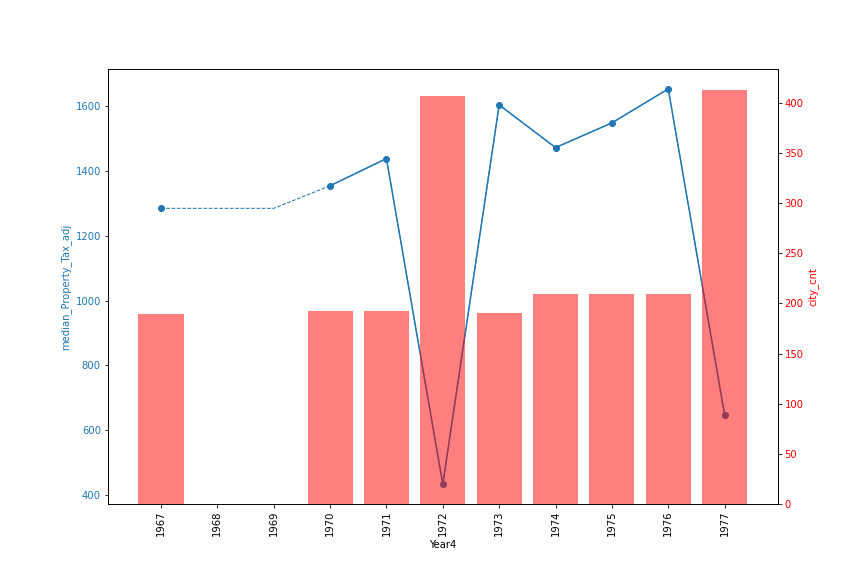

In [16]:
plot_trenedline_by_years_with_bar_chart(median_prop_tax, "Year4", "median_Property_Tax_adj", "city_cnt")

In [17]:
# calculate property tax per capita. if popoulation = 0 then check prop_tax. if prop_tax = 0, then 0 else max of property_tax_per_capita

prep_prop13["property_tax_per_capita"] = 1000 * prep_prop13["Property_Tax_adj"] / prep_prop13["Population"]
fill_val = prep_prop13.loc[np.isfinite(prep_prop13["property_tax_per_capita"]), "property_tax_per_capita"].max()
print(fill_val)

prep_prop13.loc[(prep_prop13["Population"] == 0) & (prep_prop13["Property_Tax_adj"] == 0),
                "property_tax_per_capita"] = 0
prep_prop13.loc[(prep_prop13["Population"] == 0) & (prep_prop13["Property_Tax_adj"] > 0),
                "property_tax_per_capita"] = fill_val
assert (~np.isfinite(prep_prop13["property_tax_per_capita"])).sum() == 0

16672.30769230769


<IPython.core.display.Javascript object>


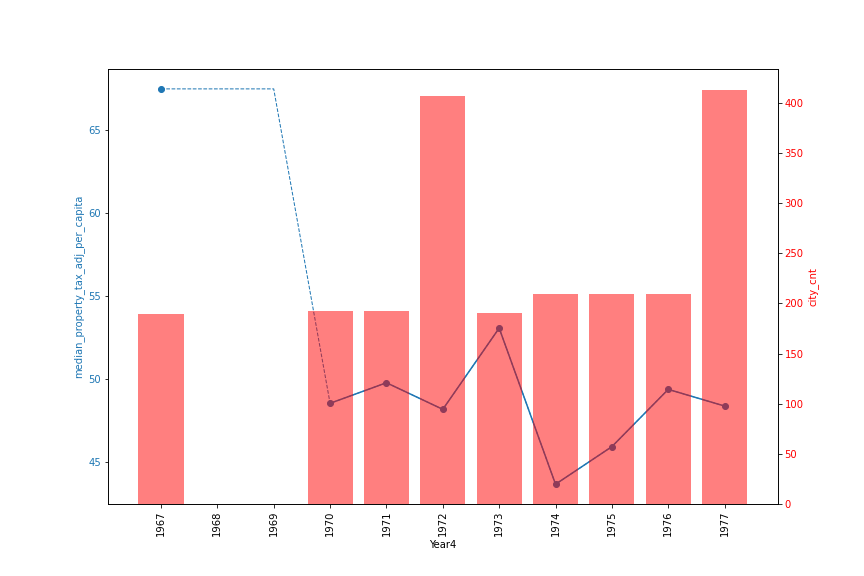

In [18]:
median_prop_tax_by_yr = prep_prop13.groupby("Year4")[["property_tax_per_capita", "Population"]].agg({
    "property_tax_per_capita": "median",
    "Population": "size"
}).reset_index()
median_prop_tax_by_yr = median_prop_tax_by_yr.rename(columns={
    "property_tax_per_capita": "median_property_tax_adj_per_capita",
    "Population": "city_cnt"
})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_by_yr, "Year4", "median_property_tax_adj_per_capita", "city_cnt")

# All years

In [19]:
# missing cnt
na_cnt_by_year = prop_tax_CA_city[["Year4"] + VAL_COLUMNS].copy().set_index("Year4").isna()
na_cnt_by_year = na_cnt_by_year.groupby("Year4").sum()
# na_cnt_by_year
# no NA

In [20]:
# prop_tax_CA_city.groupby("Year4").size()

In [21]:
base_yr = "2018" # max
inflation_adj = InflationAdj()

prop_tax_CA_city_adj = inflation_adj.inflation_adjust_df_money_col(prop_tax_CA_city, "Year4", "Property_Tax", base_yr)
prop_tax_CA_city_adj = inflation_adj.inflation_adjust_df_money_col(prop_tax_CA_city_adj, "Year4", "Total_Revenue", base_yr)

/usr/local/opt/anaconda3/envs/prop13_analysis/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [22]:
prop_tax_CA_city_adj.describe()

,Population,Total_Revenue,Property_Tax
count,1.310600e+04,1.310600e+04,1.310600e+04
mean,7.477631e+04,1.829340e+05,2.701974e+04
std,2.348586e+05,9.673926e+05,1.167584e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.059200e+04,1.249767e+04,1.664141e+03
50%,3.207150e+04,3.958569e+04,6.667928e+03
75%,7.479700e+04,1.085798e+05,2.012206e+04
max,3.971883e+06,2.198509e+07,2.264848e+06


In [23]:
prop_tax_CA_city_adj[prop_tax_CA_city_adj["ID"].isin(["052038001", "052001009"]) & (prop_tax_CA_city_adj["Year4"]<"1970")].sort_values(["ID","Year4"])

,ID,Year4,County,Name,FYEndDate,YearPop,Population,Total_Revenue,Property_Tax
315,052001009,1967,001,oakland city,0,NaN,367548,5.089799e+05,1.760745e+05
9612,052038001,1967,038,san francisco city and county,0,NaN,740316,2.916179e+06,1.070469e+06


In [24]:
# calculate property tax per capita. if popoulation = 0 then check prop_tax. if prop_tax = 0, then 0 else max of property_tax_per_capita

prop_tax_CA_city_adj["property_tax_per_capita"] = 1000 * prop_tax_CA_city_adj["Property_Tax"] / prop_tax_CA_city_adj["Population"]
fill_val = prop_tax_CA_city_adj.loc[np.isfinite(prop_tax_CA_city_adj["property_tax_per_capita"]),
                                    "property_tax_per_capita"].max()
print(fill_val)

prop_tax_CA_city_adj.loc[(prop_tax_CA_city_adj["Population"] == 0) & (prop_tax_CA_city_adj["Property_Tax"] == 0),
                         "property_tax_per_capita"] = 0
prop_tax_CA_city_adj.loc[(prop_tax_CA_city_adj["Population"] == 0) & (prop_tax_CA_city_adj["Property_Tax"] > 0),
                         "property_tax_per_capita"] = fill_val
assert (~np.isfinite(prop_tax_CA_city_adj["property_tax_per_capita"])).sum() == 0 


784290.6831906711


In [25]:
prop_tax_CA_city_adj["property_tax_per_capita"].describe()

count     13106.000000
mean       1434.333733
std       23076.243435
min           0.000000
25%         124.932347
50%         206.598507
75%         334.740730
max      784290.683191
Name: property_tax_per_capita, dtype: float64

<IPython.core.display.Javascript object>


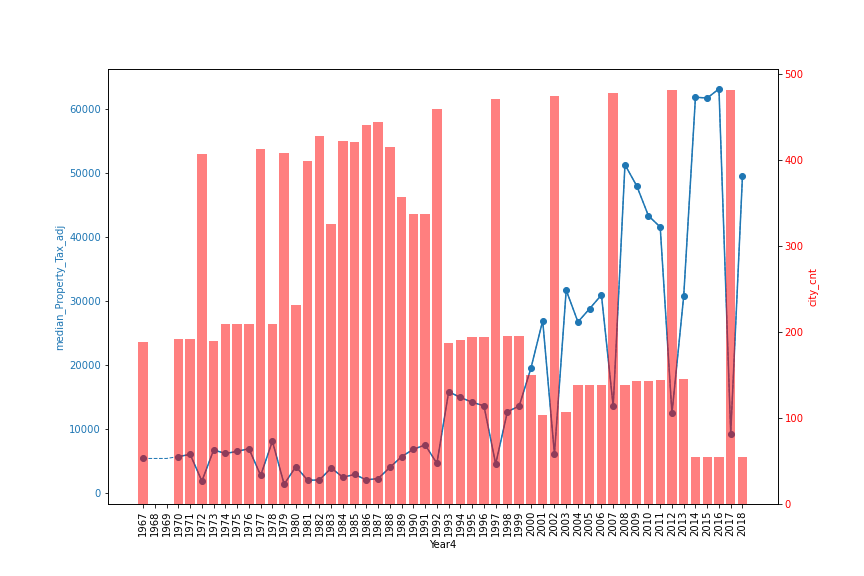

In [26]:
median_prop_tax_by_yr = prop_tax_CA_city_adj.groupby("Year4")[["Property_Tax", "Population"]].agg({
    "Property_Tax": "median",
    "Population": "size"
}).reset_index()
median_prop_tax_by_yr = median_prop_tax_by_yr.rename(columns={
    "Property_Tax": "median_Property_Tax_adj",
    "Population": "city_cnt"
})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_by_yr, "Year4", "median_Property_Tax_adj", "city_cnt")

<IPython.core.display.Javascript object>


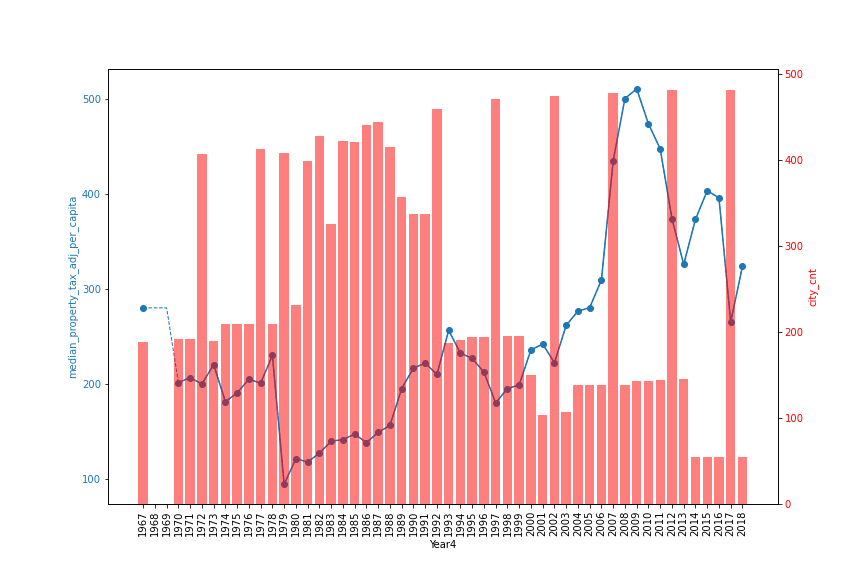

In [27]:
median_prop_tax_by_yr = prop_tax_CA_city_adj.groupby("Year4")[["property_tax_per_capita", "Population"]].agg({
    "property_tax_per_capita": "median",
    "Population": "size"
}).reset_index()
median_prop_tax_by_yr = median_prop_tax_by_yr.rename(columns={
    "property_tax_per_capita": "median_property_tax_adj_per_capita",
    "Population": "city_cnt"
})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_by_yr, "Year4", "median_property_tax_adj_per_capita", "city_cnt")

In [28]:
# consistent city from 1970 to 2013
prop_tax_CA_city_adj.head()

,ID,Year4,County,Name,FYEndDate,YearPop,Population,Total_Revenue,Property_Tax,property_tax_per_capita
0,052001001,1967,001,alameda city,630,NaN,63855,69921.272072,15671.748318,245.427113
1,052001001,1970,001,alameda city,630,NaN,70968,71712.952010,15340.155103,216.155945
2,052001001,1971,001,alameda city,630,NaN,70968,73821.605074,16180.672980,227.999563
3,052001001,1972,001,alameda city,630,NaN,70968,75796.115755,17748.002230,250.084577
4,052001001,1973,001,alameda city,6,NaN,70968,79028.767376,17388.381222,245.017208


In [29]:
pivot_year_per_capita = prop_tax_CA_city_adj[(prop_tax_CA_city_adj["Year4"] >= "1970") &
                                            (prop_tax_CA_city_adj["Year4"] <= "2013")].pivot(index="ID", columns="Year4", values="property_tax_per_capita")
pivot_year_per_capita.head()

Year4,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ID,,,,,,,,,,,,,,,,,,,,,
052001001,216.155945,227.999563,250.084577,245.017208,241.455276,237.538447,266.923561,277.788839,303.016845,89.998684,...,NaN,NaN,NaN,694.282452,NaN,NaN,NaN,NaN,597.203792,NaN
052001002,223.065229,260.125034,242.556160,278.178667,NaN,NaN,NaN,292.289224,NaN,96.145236,...,310.519428,418.384139,429.483123,540.364999,548.552751,NaN,NaN,NaN,663.998939,NaN
052001003,402.084581,478.541279,487.922011,498.815252,454.345655,428.239658,473.462425,510.161914,504.470359,178.142305,...,466.898174,641.485206,730.610589,773.812197,641.854462,701.274570,690.167184,661.350814,577.856950,679.950948
052001004,NaN,NaN,220.889356,NaN,NaN,NaN,NaN,974.546919,NaN,472.168178,...,NaN,NaN,NaN,4677.989448,NaN,NaN,NaN,NaN,3859.862314,NaN
052001005,168.820363,190.255543,203.568786,228.001389,177.958395,181.539235,192.645879,203.867317,225.803635,79.897822,...,406.836744,399.339384,434.877405,585.845453,609.602567,650.131951,618.589103,591.691992,402.917932,405.326851


In [30]:
print("city count in the whole dataset:", len(prop_tax_CA_city_adj["ID"].unique()))
consistent_cities = (~pivot_year_per_capita.isna()).sum(axis=1)
print("city count from 1970 to 2013:", len(consistent_cities))
consistent_cities = consistent_cities[consistent_cities == pivot_year_per_capita.shape[1]]
print("consistent city from 1970 to 2013:", len(consistent_cities))

consistent_cities = consistent_cities.to_frame()

# city_cnt = consistent_cities.value_counts()
# city_cnt.sort_index(ascending=False)

city count in the whole dataset: 483
city count from 1970 to 2013: 483
consistent city from 1970 to 2013: 66


In [31]:
66/483

0.13664596273291926

In [32]:
consistent_cities_70to13 = consistent_cities.merge(ID2city_name, how="left", right_on="ID", left_index=True)
consistent_cities_70to13.drop(0, axis=1).to_csv(f"{INTERIM_DATA_DIR}/66_consistent_cities_from70to13.csv")

# 66 consistent cities with property tax per capita

In [33]:
# 66 cities all have population
prop_tax_per_capita_consis_city = prop_tax_CA_city_adj[
    (prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2013")
].merge(consistent_cities, how="right", right_index=True, left_on="ID")

In [34]:
prop_tax_per_capita_consis_city["property_tax_per_capita"] = prop_tax_per_capita_consis_city["property_tax_per_capita"] 
prop_tax_per_capita_consis_city = prop_tax_per_capita_consis_city.pivot(index="ID", columns="Year4", values="property_tax_per_capita")
prop_tax_per_capita_consis_city.reset_index(inplace=True)
prop_tax_per_capita_consis_city = prop_tax_per_capita_consis_city.merge(ID2city_name, how="left", on="ID")
prop_tax_per_capita_consis_city = prop_tax_per_capita_consis_city.set_index(["ID", "County", "Name"]).sort_values("Name")


In [35]:
prop_tax_per_capita_consis_city.to_csv(f"{INTERIM_DATA_DIR}/66_consistent_cities_with_property_tax_per_capita.csv")

# 66 consistent cities with property tax proportion

In [36]:
prop_tax_pct = prop_tax_CA_city.loc[(prop_tax_CA_city["Year4"] >= "1970") & (prop_tax_CA_city["Year4"] <= "2013"),
                                   ["ID", "Year4", "Total_Revenue", "Property_Tax"]]
prop_tax_pct_66_consis_city = prop_tax_pct.merge(consistent_cities, how="left", left_on="ID", right_index=True)
prop_tax_pct_66_consis_city = prop_tax_pct_66_consis_city[~prop_tax_pct_66_consis_city[0].isna()]

In [37]:
prop_tax_pct_66_consis_city["property_tax_as_pct_of_tot_rev"] = (prop_tax_pct_66_consis_city["Property_Tax"] /
                                                                 prop_tax_pct_66_consis_city["Total_Revenue"])
prop_tax_pct_66_consis_city.drop(columns=[0, "Total_Revenue", "Property_Tax"], inplace=True)
prop_tax_pct_66_consis_city = prop_tax_pct_66_consis_city.pivot(index="ID", columns="Year4", values="property_tax_as_pct_of_tot_rev")
prop_tax_pct_66_consis_city.reset_index(inplace=True)
prop_tax_pct_66_consis_city = prop_tax_pct_66_consis_city.merge(ID2city_name, how="left", on="ID")
prop_tax_pct_66_consis_city = prop_tax_pct_66_consis_city.set_index(["ID", "County", "Name"]).sort_values("Name")

In [38]:
prop_tax_pct_66_consis_city.to_csv(f"{INTERIM_DATA_DIR}/66_consistent_cities_with_property_tax_rev_pct.csv")

# Same cities property tax per capita

<IPython.core.display.Javascript object>


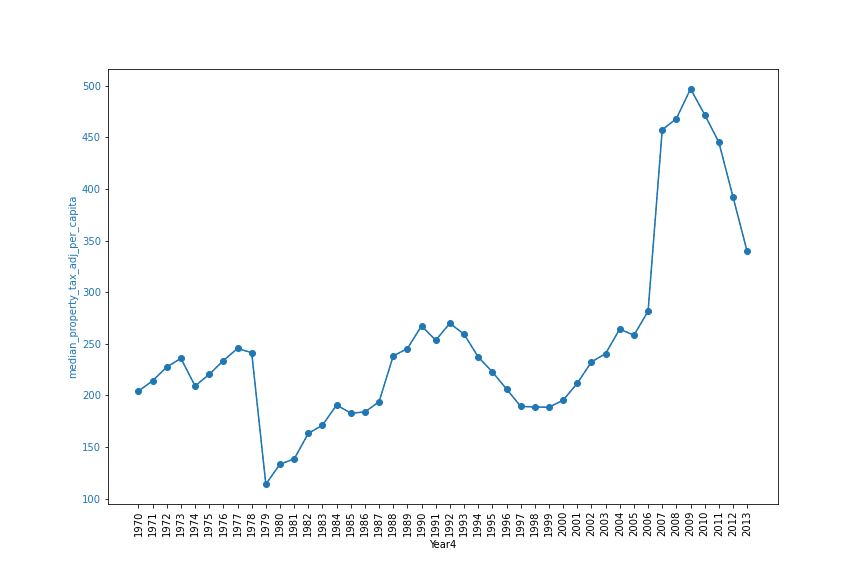

In [39]:
# trendline of property tax revenue per capita from 1970 to 2013 for 66 consistent cities
median_per_capita_consis = prop_tax_CA_city_adj[
    (prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2013")
].merge(consistent_cities, how="right", right_index=True, left_on="ID")
median_per_capita_consis = median_per_capita_consis.groupby("Year4")[["property_tax_per_capita"]].median().reset_index()
median_per_capita_consis = median_per_capita_consis.rename(columns={"property_tax_per_capita": "median_property_tax_adj_per_capita"})
median_per_capita_consis = median_per_capita_consis.merge(median_prop_tax_by_yr[["Year4", "city_cnt"]], how="left", on="Year4")
plot_trenedline_by_years_with_bar_chart(median_per_capita_consis, "Year4", "median_property_tax_adj_per_capita", "city_cnt", show_bar=False)

<IPython.core.display.Javascript object>


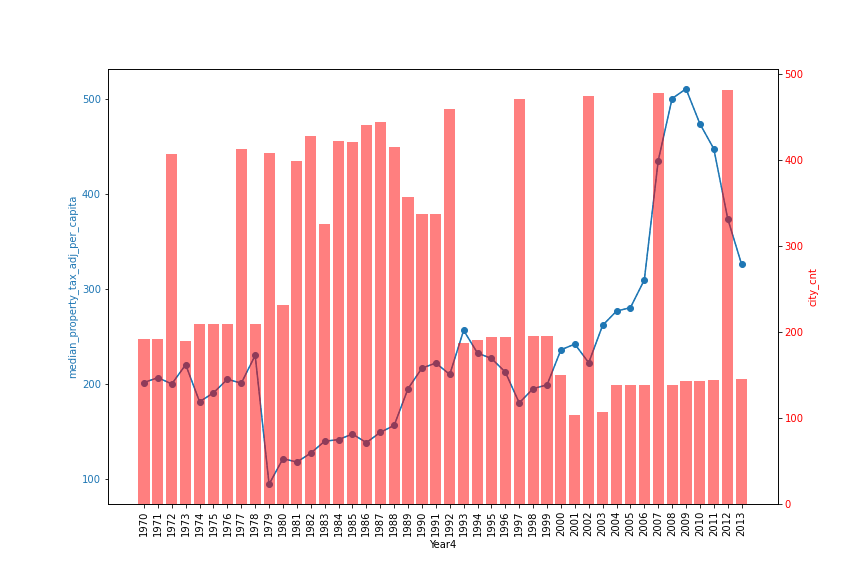

In [40]:
median_prop_tax_by_yr = prop_tax_CA_city_adj[(prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2013")].groupby("Year4")[["property_tax_per_capita", "Population"]].agg({
    "property_tax_per_capita": "median",
    "Population": "size"
}).reset_index()
median_prop_tax_by_yr = median_prop_tax_by_yr.rename(columns={
    "property_tax_per_capita": "median_property_tax_adj_per_capita",
    "Population": "city_cnt"
})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_by_yr, "Year4", "median_property_tax_adj_per_capita", "city_cnt")

In [41]:

def dual_axis_trendlines_with_annotation(df, x_col, y1_col, y2_col, y2_anno_col=None):
    # plot
    fig, ax1 = plt.subplots(figsize=(12,8))
    
    yr_num = pd.to_numeric(df[x_col])
    plt.xticks(np.arange(yr_num.min(), yr_num.max()+1, 1))
    
    line1, = ax1.plot(pd.to_numeric(df[x_col]),
             df[y1_col],
             marker="o",
             lw=1.5)
    line_color = line1.get_color()
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(y1_col, color=line_color)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.tick_params(axis='y', labelcolor=line_color)
    
    ax2 = ax1.twinx() 
    ax2_color = "r"
    mask = ~df[y2_col].isna()
    x2 = pd.to_numeric(df.loc[mask, x_col])
    y2 = df.loc[mask, y2_col]
    
    line2 = ax2.plot(x2, y2, 
             marker="o",
             color=ax2_color, lw=1.5, linestyle="solid")
    ax2.set_ylabel(y2_col, color=ax2_color)
    ax2.tick_params(axis='y', labelcolor=ax2_color)

    if y2_anno_col is not None:
        for x,y,a in zip(x2, y2, df.loc[mask, y2_anno_col]):
            ax2.annotate(f"{int(a)} cities", (x, y), 
                         textcoords="offset points", xytext=(0,5), ha='center'
                        )
    
    # right click to show
    cursor1 = mplcursors.cursor(line1, hover=False)
    cursor2 = mplcursors.cursor(line2, hover=False)
    
    plt.show()

In [42]:
# from 1970 to 2018
pivot_year_per_capita_70to18 = prop_tax_CA_city_adj[(prop_tax_CA_city_adj["Year4"] >= "1970") &
                                                    (prop_tax_CA_city_adj["Year4"] <= "2018")].pivot(index="ID", columns="Year4", values="property_tax_per_capita")

cities_70to18 = (~pivot_year_per_capita_70to18.isna()).sum(axis=1)
print("city count from 1970 to 2018:", len(cities_70to18))
consistent_cities_70to18 = cities_70to18[cities_70to18 == pivot_year_per_capita_70to18.shape[1]]
print("consistent city from 1970 to 2018:", len(consistent_cities_70to18))
print(f"consistent city ratio:{len(consistent_cities_70to18)/len(cities_70to18)}")

consistent_cities_70to18 = consistent_cities_70to18.to_frame()
consistent_cities_70to18 = consistent_cities_70to18.merge(ID2city_name, how="left", right_index=True, left_index=True)
consistent_cities_70to18.drop(0, axis=1).to_csv(f"{INTERIM_DATA_DIR}/34_consistent_cities_from70to18.csv")

city count from 1970 to 2018: 483
consistent city from 1970 to 2018: 34
consistent city ratio:0.07039337474120083


In [43]:
consistent_cities_70to18

,0,County,Name
ID,,,
052001003,49,001,berkeley city
052001005,49,001,fremont city
052001009,49,001,oakland city
052010005,49,010,fresno city
052015001,49,015,bakersfield city
052019008,49,019,burbank city
052019017,49,019,glendale city
052019022,49,019,inglewood city
052019026,49,019,long beach city


<IPython.core.display.Javascript object>


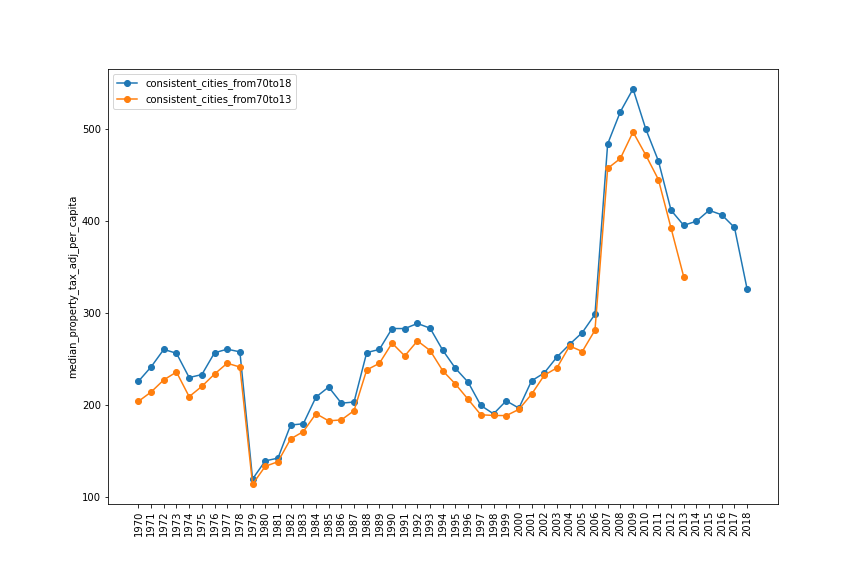

In [44]:
# trendline of property tax revenue per capita from 1970 to 2018 for 34 consistent cities
median_per_capita_consis_70to18 = prop_tax_CA_city_adj[
    (prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2018")
].merge(consistent_cities_70to18, how="right", right_index=True, left_on="ID")
median_per_capita_consis_70to18 = median_per_capita_consis_70to18.groupby("Year4")[["property_tax_per_capita"]].median().reset_index()
median_per_capita_consis_70to18 = median_per_capita_consis_70to18.rename(columns={"property_tax_per_capita": "median_property_tax_adj_per_capita"})

comp_2_consis = median_per_capita_consis_70to18.merge(median_per_capita_consis, how="outer", on="Year4",
                                                      suffixes=("_70to18", "_70to13"))
comp_2_consis.drop("city_cnt", axis=1, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
line1, = ax.plot(comp_2_consis["Year4"],
             comp_2_consis["median_property_tax_adj_per_capita_70to18"],
             marker="o",
             lw=1.5)
line2, = ax.plot(comp_2_consis["Year4"],
             comp_2_consis["median_property_tax_adj_per_capita_70to13"],
             marker="o",
             lw=1.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel("median_property_tax_adj_per_capita")
ax.legend([line1, line2], ['consistent_cities_from70to18', 'consistent_cities_from70to13'])
plt.show()


<IPython.core.display.Javascript object>


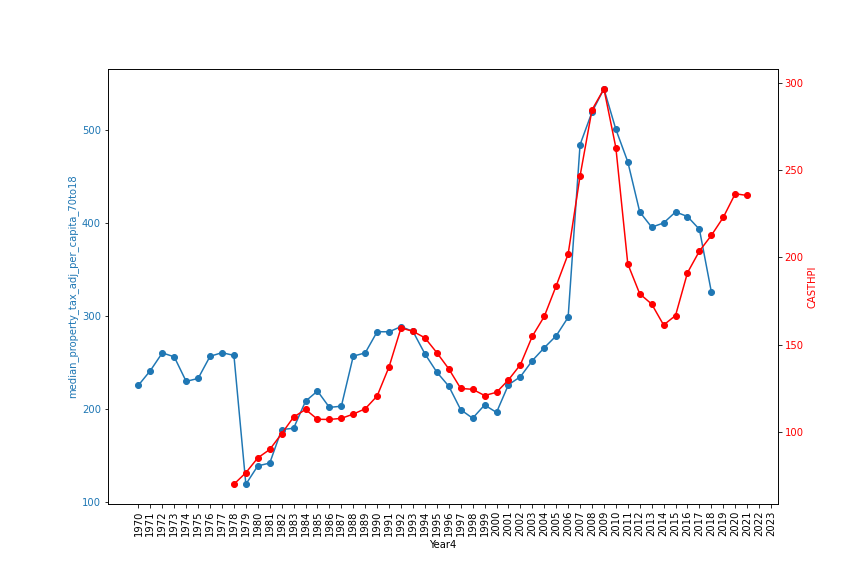

In [45]:
# U.S. Federal Housing Finance Agency, All-Transactions House Price Index for California [CASTHPI], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CASTHPI
# Units:  Index 1980:Q1=100, Not Seasonally Adjusted

cahpi = pd.read_csv(f"{RAW_DATA_DIR}/market_value/CASTHPI.csv")
cahpi["Year4"] = cahpi["DATE"].map(lambda x: str(int(x.split("-")[0])+3))
cahpi.drop("DATE", axis=1, inplace=True)
cahpi["CASTHPI"] = pd.to_numeric(cahpi["CASTHPI"], errors="coerce") # remove "."
cahpi = cahpi.dropna()
cahpi = inflation_adj.inflation_adjust_df_money_col(cahpi, "Year4", "CASTHPI", "1983")
comp_hpi = comp_2_consis.merge(cahpi, how="outer", on="Year4")
dual_axis_trendlines_with_annotation(comp_hpi, "Year4", "median_property_tax_adj_per_capita_70to18", "CASTHPI")

In [46]:
# similar pattern for 66 consistent cities
# comp_hpi = median_per_capita_consis.merge(cahpi, how="outer", on="Year4")
# dual_axis_trendlines_with_annotation(comp_hpi, "Year4", "median_property_tax_adj_per_capita", "CASTHPI")

# Same cities property tax

<IPython.core.display.Javascript object>


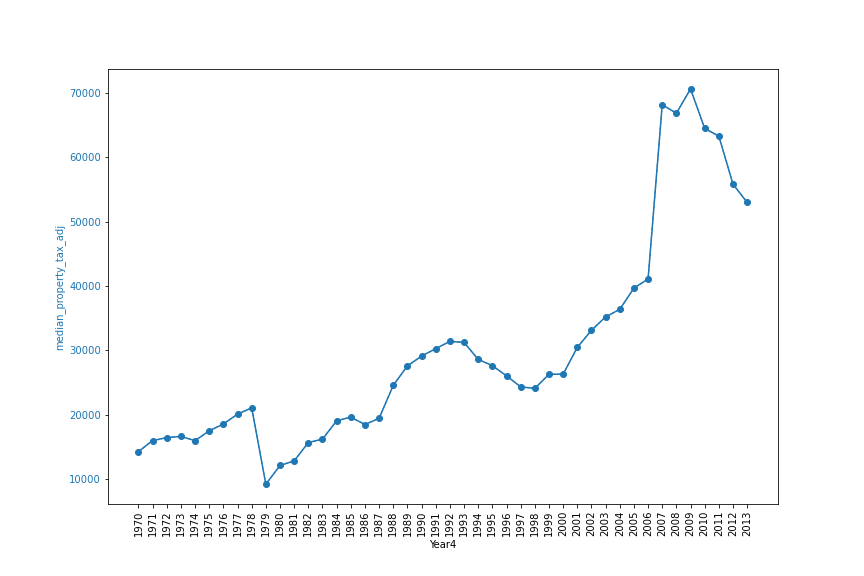

In [47]:
median_prop_tax_consis = prop_tax_CA_city_adj[
    (prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2013")
].merge(consistent_cities, how="right", right_index=True, left_on="ID")
median_prop_tax_consis = median_prop_tax_consis.groupby("Year4")[["Property_Tax"]].median().reset_index()
median_prop_tax_consis = median_prop_tax_consis.rename(columns={"Property_Tax": "median_property_tax_adj"})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_consis, "Year4", "median_property_tax_adj", show_bar=False)

<IPython.core.display.Javascript object>


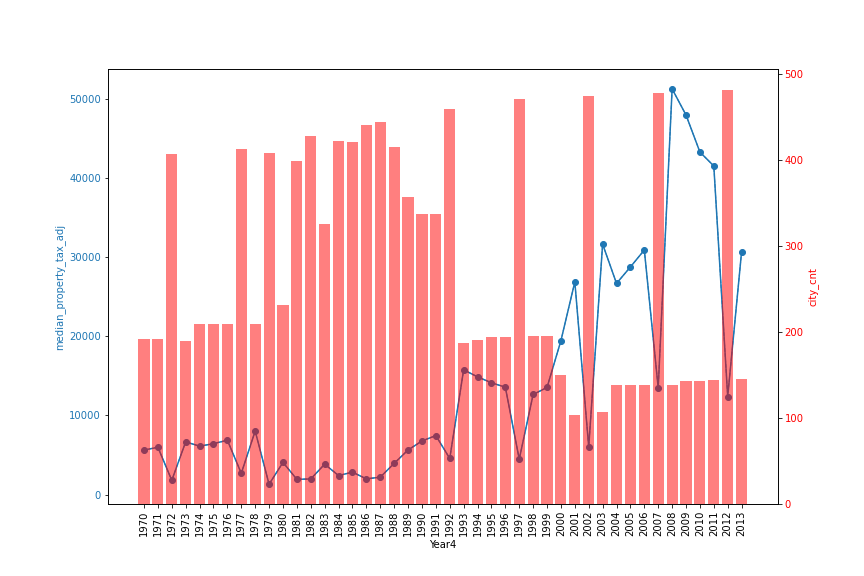

In [48]:
median_prop_tax_by_yr = prop_tax_CA_city_adj[(prop_tax_CA_city_adj["Year4"] >= "1970") & (prop_tax_CA_city_adj["Year4"] <= "2013")].groupby("Year4")[["Property_Tax", "Population"]].agg({
    "Property_Tax": "median",
    "Population": "size"
}).reset_index()
median_prop_tax_by_yr = median_prop_tax_by_yr.rename(columns={
    "Property_Tax": "median_property_tax_adj",
    "Population": "city_cnt"
})
plot_trenedline_by_years_with_bar_chart(median_prop_tax_by_yr, "Year4", "median_property_tax_adj", "city_cnt",
#                                         show_bar=False,
                                       )


<IPython.core.display.Javascript object>


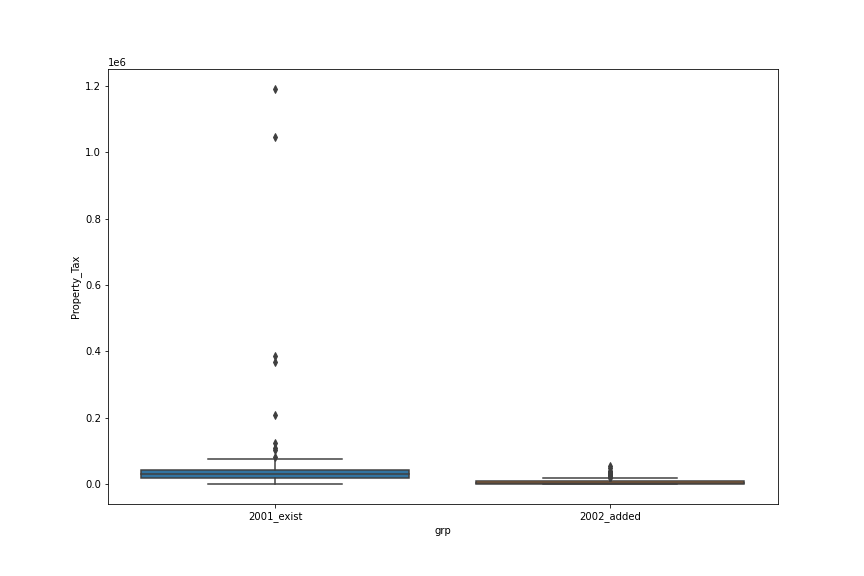

In [49]:
# take a look at 2001, 2002

prop_tax_2001 = prop_tax_CA_city_adj.loc[prop_tax_CA_city_adj["Year4"] == "2001", ["ID", "Year4"]].copy()
prop_tax_2002 = prop_tax_CA_city_adj[prop_tax_CA_city_adj["Year4"] == "2002"].copy()
prop_tax_2002 = prop_tax_2002.merge(prop_tax_2001, how="left", on="ID", suffixes=("_02", "_01"))
prop_tax_2002["grp"] = prop_tax_2002["Year4_01"].map({"2001": "2001_exist", np.NaN: "2002_added"})
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="grp", y="Property_Tax", data=prop_tax_2002)
plt.show()

<IPython.core.display.Javascript object>


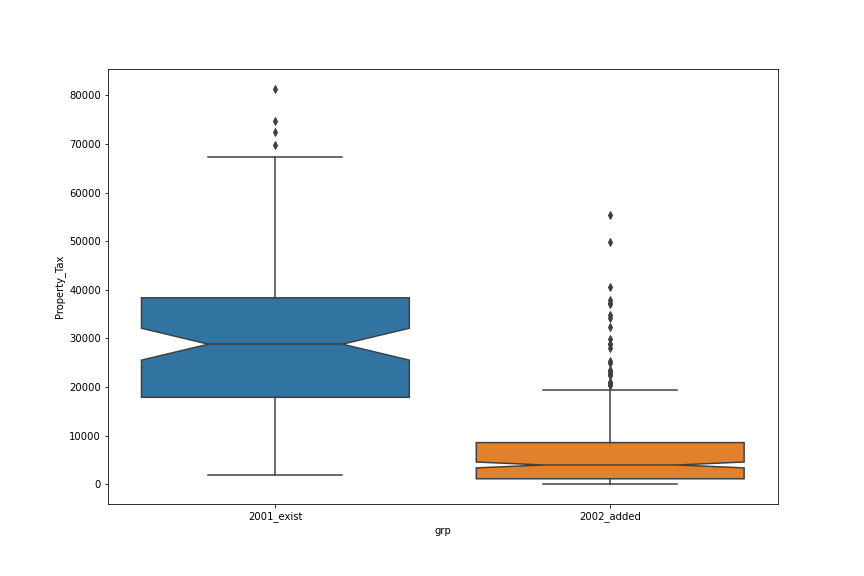

55473.99864369094 < 8.3e4


In [50]:
fig, ax = plt.subplots(figsize=(12,8))
print(f'{prop_tax_2002.loc[prop_tax_2002["grp"] == "2002_added", "Property_Tax"].max()} < 8.3e4')
ax = sns.boxplot(x="grp", y="Property_Tax", data=prop_tax_2002[prop_tax_2002["Property_Tax"] < 8.3e4], notch=True)
plt.show()

In [51]:
prop_tax_2002[["grp", "Property_Tax"]].groupby("grp").agg(["size", np.mean, np.median])

Property_Tax                            
                   size          mean        median
grp                                                
2001_exist          104  62747.477904  31970.666651
2002_added          371   6533.797658   3986.440767

<IPython.core.display.Javascript object>


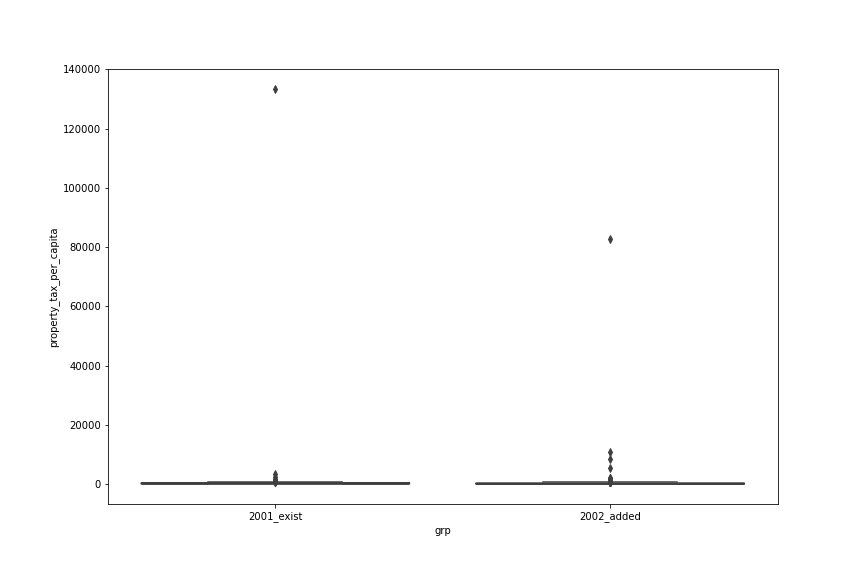

In [52]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="grp", y="property_tax_per_capita", data=prop_tax_2002, notch=True)
plt.show()

<IPython.core.display.Javascript object>


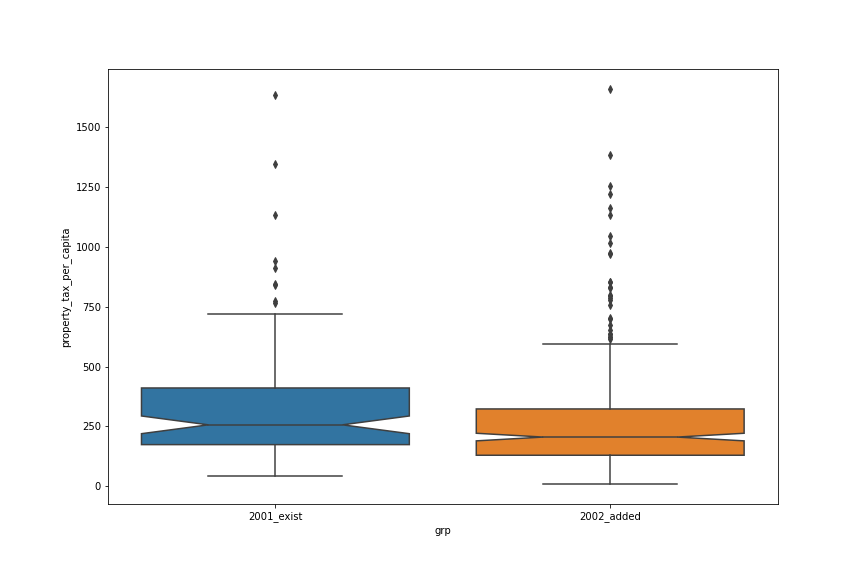

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="grp",
                 y="property_tax_per_capita", 
                 data=prop_tax_2002[prop_tax_2002["property_tax_per_capita"]<2000],notch=True
                )
plt.show()

In [54]:
def get_boxplot_median_CI(ax, labels=[]):
    boxes = ax["boxes"]
    if len(labels)!= len(boxes):
        raise Exception("the number of labels and the number of the boxplot groups are not consistent")
    
    res = dict()
    for i, box in enumerate(boxes):
        res[labels[i]] = [box.get_ydata()[4]]
        res[labels[i]].append(box.get_ydata()[2])
    
    res = pd.DataFrame(res, index=["upper_CI", "lower_CI"])
    return res

<IPython.core.display.Javascript object>


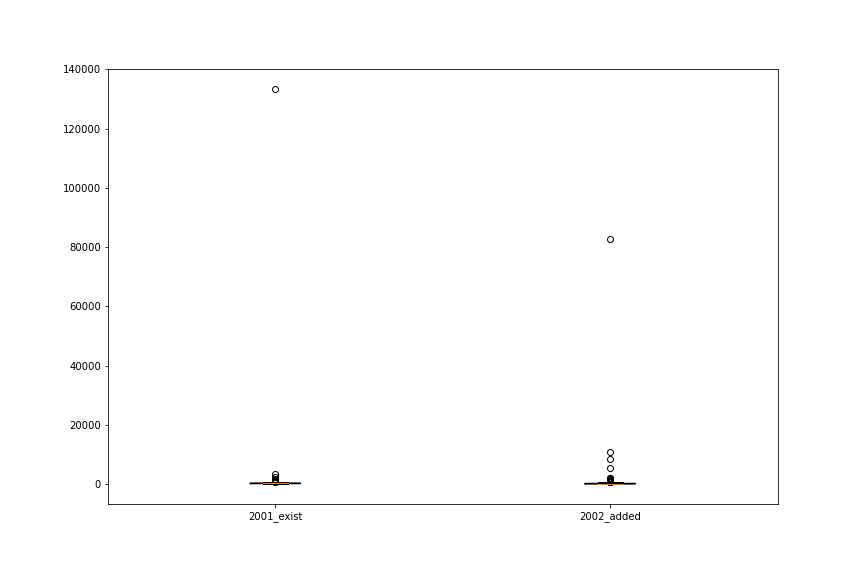

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
labels=["2001_exist", "2002_added"]
ax = plt.boxplot([prop_tax_2002.loc[prop_tax_2002["grp"] == labels[0], "property_tax_per_capita"].values,
                 prop_tax_2002.loc[prop_tax_2002["grp"] == labels[1], "property_tax_per_capita"].values], 
                 labels=labels,
                 notch=True)
plt.show()

In [56]:
print(get_boxplot_median_CI(ax, labels))

          2001_exist  2002_added
upper_CI  296.834278  227.594516
lower_CI  220.844504  194.099651


# number of properties

In [57]:
PROP_CNT_AV_STR_COLS = ['ID', 'State', 'Type', 'County', 'Area', 'Table', 'Page', 'Year', 'Notes']
PROP_CNT_AV_VAL_COLS_MAP = {
    'Pop': 'Population',
    'Real_Parcels_Loc_Tot': 'Real_Parcels_Local_Total', 
    'Perc_Parcels_Loc_Tot': 'Percent_Real_Parcels_Local_Total',
    'Perc_Parcels_Loc_Res_Tot': 'Percent_Real_Parcels_Local_Resident_Total',
    'Perc_Parcels_Loc_Res_Sgl': 'Percent_Real_Parcels_Local_Resident_Single',
    'Perc_Parcels_Loc_Acreage': 'Percent_Real_Parcels_Local_Acreage',
    'Perc_Parcels_Loc_Vacant': 'Percent_Real_Parcels_Local_Vacant',
    'Perc_Parcels_Loc_ComInd': 'Percent_Real_Parcels_Local_Comm__Ind',
    'Perc_Parcels_Loc_Com': 'Percent_Real_Parcels_Local_Commercial',
    'Perc_Parcels_Loc_Ind': 'Percent_Real_Parcels_Local_Industrial',
    'Perc_Parcels_Loc_Oth': 'Percent_Real_Parcels_Local_Other',
    'GAV_Loc_Real_Tot': 'Gross_AV_Local_Real_Total',
    'Perc_GAV_Loc_Real_Tot': 'Percent_Gross_AV_Local_Real_Total',
    'Perc_GAV_Loc_Res_Tot': 'Percent_Gross_AV_Local_Resident_Total',
    'Perc_GAV_Loc_Res_Sgl': 'Percent_Gross_AV_Local_Resident_Single',
    'Perc_GAV_Loc_Acreage': 'Percent_Gross_AV_Local_Acreage',
    'Perc_GAV_Loc_Vacant': 'Percent_Gross_AV_Local_Vacant',
    'Perc_GAV_Loc_ComInd': 'Percent_Gross_AV_Local_Comm__Ind',
    'Perc_GAV_Loc_Com': 'Percent_Gross_AV_Local_Commercial',
    'Perc_GAV_Loc_Ind': 'Percent_Gross_AV_Local_Industrial',
    'Perc_GAV_Loc_Oth': 'Percent_Gross_AV_Local_Other'
}
prop_cnt_av = pd.read_excel(
    f"{RAW_DATA_DIR}/Prop 13 Resources/Prop-13 Impact Analysis (Kendall)/Assessed Values/TPV - Table CoArea2. Locally Assessed Taxable Real Property for Selected Local Areas, by Property Use Category.xlsx",
    header=0,
    skiprows=[i for i in range(11)],
    dtype={col: str for col in PROP_CNT_AV_STR_COLS}
)

prop_cnt_av.rename(columns=PROP_CNT_AV_VAL_COLS_MAP, inplace=True)

In [58]:
prop_cnt_av.columns

Index(['ID', 'State', 'Type', 'County', 'Area', 'Table', 'Page', 'Year',
       'Notes', 'Population', 'Real_Parcels_Local_Total',
       'Percent_Real_Parcels_Local_Total',
       'Percent_Real_Parcels_Local_Resident_Total',
       'Percent_Real_Parcels_Local_Resident_Single',
       'Percent_Real_Parcels_Local_Acreage',
       'Percent_Real_Parcels_Local_Vacant',
       'Percent_Real_Parcels_Local_Comm__Ind',
       'Percent_Real_Parcels_Local_Commercial',
       'Percent_Real_Parcels_Local_Industrial',
       'Percent_Real_Parcels_Local_Other', 'Gross_AV_Local_Real_Total',
       'Percent_Gross_AV_Local_Real_Total',
       'Percent_Gross_AV_Local_Resident_Total',
       'Percent_Gross_AV_Local_Resident_Single',
       'Percent_Gross_AV_Local_Acreage', 'Percent_Gross_AV_Local_Vacant',
       'Percent_Gross_AV_Local_Comm__Ind', 'Percent_Gross_AV_Local_Commercial',
       'Percent_Gross_AV_Local_Industrial', 'Percent_Gross_AV_Local_Other'],
      dtype='object')

In [59]:
CA_prop_cnt_av = prop_cnt_av[prop_cnt_av["State"] == "05"].copy()

In [60]:
# clean str columns
clean_str_cols(CA_prop_cnt_av, PROP_CNT_AV_STR_COLS)

check_missing_values_all_cols(CA_prop_cnt_av)

{'Page': 502, 'Notes': 493}


In [61]:
CA_city_prop_cnt_av = CA_prop_cnt_av[CA_prop_cnt_av["Type"] == "2"].copy()


In [62]:
# no id + year duplicates
_dup = CA_city_prop_cnt_av.groupby(["Year", "ID"]).size().to_frame()
assert _dup[_dup[0] > 1].empty

# ID is 9-digits

# fix typo
CA_city_prop_cnt_av.loc[CA_city_prop_cnt_av["ID"] == "052030504", "Area"] = "westminster city" 
CA_city_prop_cnt_av.loc[CA_city_prop_cnt_av["ID"] == "052038001", "Area"] = "san francisco city and county"

In [63]:
CA_city_prop_cnt_av.describe()

,Population,Real_Parcels_Local_Total,Percent_Real_Parcels_Local_Total,Percent_Real_Parcels_Local_Resident_Total,Percent_Real_Parcels_Local_Resident_Single,Percent_Real_Parcels_Local_Acreage,Percent_Real_Parcels_Local_Vacant,Percent_Real_Parcels_Local_Comm__Ind,Percent_Real_Parcels_Local_Commercial,Percent_Real_Parcels_Local_Industrial,...,Gross_AV_Local_Real_Total,Percent_Gross_AV_Local_Real_Total,Percent_Gross_AV_Local_Resident_Total,Percent_Gross_AV_Local_Resident_Single,Percent_Gross_AV_Local_Acreage,Percent_Gross_AV_Local_Vacant,Percent_Gross_AV_Local_Comm__Ind,Percent_Gross_AV_Local_Commercial,Percent_Gross_AV_Local_Industrial,Percent_Gross_AV_Local_Other
count,3.010000e+02,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,3.010000e+02,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.00000,301.000000
mean,1.915701e+05,49394.232558,-6157.302326,-6162.298339,-6166.806312,-6201.309635,-6199.333887,-6198.887375,-9486.075083,-9486.603987,...,2.791133e+06,-86.229236,-116.420930,-131.208306,-183.934884,-181.676412,-158.366113,-9484.251495,-9485.08206,-221.021595
std,4.046856e+05,97476.159308,5576.746954,5571.123535,5566.051346,5527.204725,5529.429490,5529.931830,3933.653944,3932.373499,...,7.781974e+06,1435.262491,1431.362935,1429.454297,1422.543257,1422.838589,1425.902320,3938.068984,3936.05975,1555.659377
min,-1.111100e+04,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,...,-1.111100e+04,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.00000,-11111.000000
25%,6.692200e+04,17724.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,...,2.891470e+05,100.000000,63.100000,46.700000,0.000000,1.200000,19.500000,-11111.000000,-11111.00000,0.000000
50%,8.660300e+04,23632.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,-11111.000000,...,1.343021e+06,100.000000,69.700000,54.200000,0.100000,2.300000,25.800000,-11111.000000,-11111.00000,0.000000
75%,1.283380e+05,35196.000000,100.000000,88.200000,78.700000,0.000000,3.500000,5.000000,-11111.000000,-11111.000000,...,2.712303e+06,100.000000,76.100000,60.900000,0.700000,3.900000,31.800000,-11111.000000,-11111.00000,0.300000
max,3.259295e+06,725949.000000,100.000000,97.300000,97.100000,10.700000,26.300000,14.900000,11.100000,3.900000,...,1.018773e+08,100.000000,90.400000,90.100000,10.700000,12.300000,63.300000,32.100000,48.60000,22.600000


In [64]:
for col in PROP_CNT_AV_VAL_COLS_MAP.values():
    CA_city_prop_cnt_av.loc[CA_city_prop_cnt_av[col] == -11111, col] = np.NaN

CA_city_prop_cnt_av.describe()

,Population,Real_Parcels_Local_Total,Percent_Real_Parcels_Local_Total,Percent_Real_Parcels_Local_Resident_Total,Percent_Real_Parcels_Local_Resident_Single,Percent_Real_Parcels_Local_Acreage,Percent_Real_Parcels_Local_Vacant,Percent_Real_Parcels_Local_Comm__Ind,Percent_Real_Parcels_Local_Commercial,Percent_Real_Parcels_Local_Industrial,...,Gross_AV_Local_Real_Total,Percent_Gross_AV_Local_Real_Total,Percent_Gross_AV_Local_Resident_Total,Percent_Gross_AV_Local_Resident_Single,Percent_Gross_AV_Local_Acreage,Percent_Gross_AV_Local_Vacant,Percent_Gross_AV_Local_Comm__Ind,Percent_Gross_AV_Local_Commercial,Percent_Gross_AV_Local_Industrial,Percent_Gross_AV_Local_Other
count,2.980000e+02,296.000000,133.0,133.000000,133.000000,133.000000,133.000000,133.000000,44.000000,44.000000,...,2.980000e+02,296.0,296.000000,296.000000,296.000000,296.000000,296.000000,44.000000,44.000000,295.000000
mean,1.936105e+05,50416.280405,100.0,88.693233,78.490977,0.404511,4.875940,5.886466,4.963636,1.345455,...,2.819344e+06,100.0,69.298311,54.261149,0.643919,2.940541,26.644595,17.438636,11.756818,0.469492
std,4.062088e+05,97977.286852,0.0,4.944804,9.725026,1.425837,3.881154,2.594568,2.102500,0.951731,...,7.816055e+06,0.0,9.493403,11.741317,1.317251,2.352174,9.479625,5.440170,10.358895,1.702744
min,5.007700e+04,7768.000000,100.0,60.900000,51.100000,0.000000,0.000000,1.100000,1.000000,0.000000,...,9.064300e+04,100.0,32.300000,24.700000,0.000000,0.000000,5.400000,6.500000,0.400000,0.000000
25%,6.774725e+04,17866.500000,100.0,86.000000,71.300000,0.000000,1.900000,3.900000,3.250000,0.600000,...,2.985138e+05,100.0,63.575000,47.700000,0.000000,1.275000,19.775000,15.150000,3.650000,0.000000
50%,8.755050e+04,23817.500000,100.0,89.000000,79.700000,0.000000,4.400000,5.600000,4.900000,1.200000,...,1.361758e+06,100.0,69.900000,54.450000,0.100000,2.300000,26.000000,17.150000,9.100000,0.000000
75%,1.295118e+05,35393.000000,100.0,92.000000,85.200000,0.200000,7.100000,7.300000,6.275000,2.000000,...,2.724765e+06,100.0,76.650000,60.950000,0.700000,4.000000,31.900000,19.725000,13.450000,0.300000
max,3.259295e+06,725949.000000,100.0,97.300000,97.100000,10.700000,26.300000,14.900000,11.100000,3.900000,...,1.018773e+08,100.0,90.400000,90.100000,10.700000,12.300000,63.300000,32.100000,48.600000,22.600000


In [65]:
CA_city_prop_cnt_av.shape

(301, 30)

In [66]:
CA_city_prop_cnt_av.loc[CA_city_prop_cnt_av["ID"].isin(["052038001", "052001009"]),
                        ["Area", "Year"] + ["Real_Parcels_Local_Total", "Percent_Real_Parcels_Local_Resident_Total",
                        "Gross_AV_Local_Real_Total", "Percent_Gross_AV_Local_Resident_Total"]].sort_values(["Area", "Year"])

,Area,Year,Real_Parcels_Local_Total,Percent_Real_Parcels_Local_Resident_Total,Gross_AV_Local_Real_Total,Percent_Gross_AV_Local_Resident_Total
4975,oakland city,1962,95932.0,NaN,437427.0,62.2
4229,oakland city,1967,95855.0,NaN,543014.0,60.2
4083,oakland city,1972,92683.0,83.2,854734.0,68.7
2958,oakland city,1977,93665.0,NaN,1046263.0,67.7
1784,oakland city,1982,97094.0,NaN,5999950.0,70.9
104,oakland city,1987,103805.0,85.6,9260423.0,69.0
5591,san francisco city and county,1957,152062.0,NaN,929400.0,50.3
4994,san francisco city and county,1962,151118.0,NaN,1041073.0,54.2
4258,san francisco city and county,1967,148301.0,NaN,1225167.0,54.2
4130,san francisco city and county,1972,148450.0,87.7,1924422.0,58.9


In [67]:
real_property_cnt = CA_city_prop_cnt_av[["Year", "Real_Parcels_Local_Total"]].copy()
real_property_cnt["city_cnt_with_valid_property_cnt"] = ~real_property_cnt["Real_Parcels_Local_Total"].isna()
real_property_cnt = real_property_cnt.groupby("Year").agg({"city_cnt_with_valid_property_cnt": sum,
                                                           "Real_Parcels_Local_Total": np.median})
real_property_cnt.rename(columns={"Real_Parcels_Local_Total": "Median_Real_Parcels_Local_Total"}, inplace=True)
real_property_cnt.reset_index(inplace=True)

real_property_cnt.sort_values("Year")

,Year,city_cnt_with_valid_property_cnt,Median_Real_Parcels_Local_Total
0,1957,1,152062.0
1,1962,5,146822.0
2,1967,14,62614.0
3,1972,44,21471.5
4,1977,67,21287.0
5,1982,76,24133.0
6,1987,89,23818.0


In [68]:
real_property_cnt_enough_samples = real_property_cnt[real_property_cnt["city_cnt_with_valid_property_cnt"] > 5].copy()

def merge_with_prop_tax_by_year(prop_tax_df, tpv_df):
    merge_df = prop_tax_df.merge(tpv_df, how="outer", left_on="Year4", right_on="Year")
    merge_df["Year"] = np.where(merge_df["Year4"].isna(),
                                merge_df["Year"],
                                merge_df["Year4"])
    merge_df.drop(["Year4", "city_cnt"], axis=1, inplace=True)
    return merge_df.sort_values("Year")

comp_prop_tax_prop_cnt = merge_with_prop_tax_by_year(median_per_capita_consis, real_property_cnt_enough_samples)


In [69]:
real_property_cnt_enough_samples

,Year,city_cnt_with_valid_property_cnt,Median_Real_Parcels_Local_Total
2,1967,14,62614.0
3,1972,44,21471.5
4,1977,67,21287.0
5,1982,76,24133.0
6,1987,89,23818.0


<IPython.core.display.Javascript object>


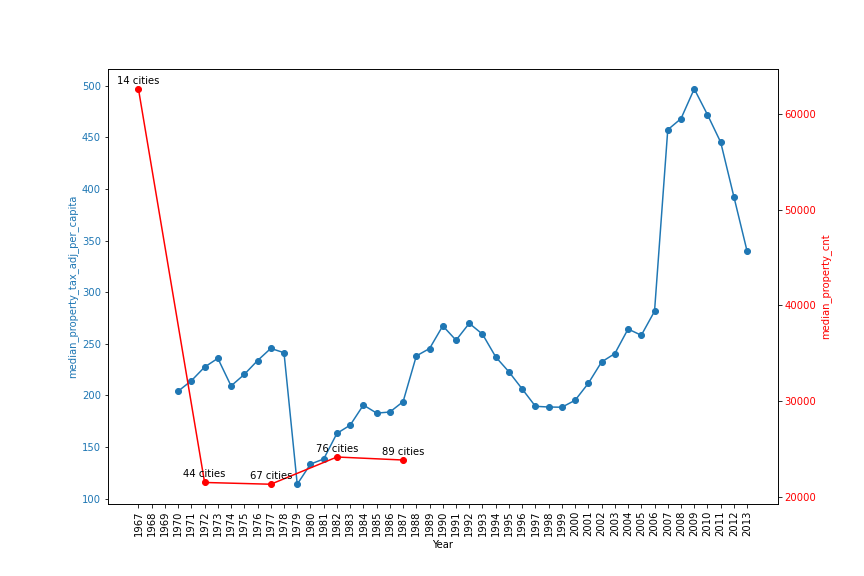

In [70]:
comp_prop_tax_prop_cnt.rename(columns={"Median_Real_Parcels_Local_Total": "median_property_cnt"}, inplace=True)
dual_axis_trendlines_with_annotation(comp_prop_tax_prop_cnt, "Year",
                                     "median_property_tax_adj_per_capita", "median_property_cnt",
                                     "city_cnt_with_valid_property_cnt")

In [71]:
consis_real_prop_cnt = CA_city_prop_cnt_av.loc[(~CA_city_prop_cnt_av["Real_Parcels_Local_Total"].isna()) &
                                               (CA_city_prop_cnt_av["Year"] >= "1967"), # yr < 1967 with <= 5 cities
                                               ["ID", "County", "Area", "Year", "Real_Parcels_Local_Total"]].copy()
consis_real_prop_cnt = consis_real_prop_cnt.pivot(index=["ID", "County", "Area"], columns="Year", values="Real_Parcels_Local_Total")


In [72]:
_df = consis_real_prop_cnt.reset_index()

assert all(_df.groupby("ID").size() == 1) 
assert all(_df.groupby(["County", "Area"]).size() == 1) 

In [73]:
def get_consis_cities_median_by_year(consis_real_prop_cnt, consis_years):
    bool_real_prop_cnt = ~consis_real_prop_cnt.isna()

    # init all True
    _mask = consis_real_prop_cnt.index.values != 1
    for yr in consis_years:
        _mask = _mask & bool_real_prop_cnt[yr]
    
    _df = consis_real_prop_cnt[_mask].reset_index()
    print(f"{_df.shape[0]} consistent cities for {consis_years}")
    print(_df["Area"].unique())
    _df = _df[consis_years].median().to_frame()
    return _df.rename(columns={0:"median_property_cnt"}).reset_index()


In [74]:
consis_years = ["1972","1977","1982","1987"]

_consis_real_prop_cnt = get_consis_cities_median_by_year(consis_real_prop_cnt, consis_years)

43 consistent cities for ['1972', '1977', '1982', '1987']
['alameda city' 'berkeley city' 'fremont city' 'hayward city'
 'oakland city' 'san leandro city' 'concord city' 'richmond city'
 'alhambra city' 'burbank city' 'compton city' 'el monte city'
 'glendale city' 'hawthorne city' 'inglewood city' 'lakewood city'
 'long beach city' 'los angeles city' 'pasadena city' 'pomona city'
 'santa monica city' 'torrance city' 'west covina city' 'whittier city'
 'downey city' 'bellflower city' 'norwalk city' 'pico rivera city'
 'riverside city' 'ontario city' 'san bernardino city' 'chula vista city'
 'el cajon city' 'san diego city' 'san francisco city and county'
 'daly city' 'redwood city' 'san mateo city' 'mountain view city'
 'palo alto city' 'san jose city' 'santa clara city' 'sunnyvale city']


<IPython.core.display.Javascript object>


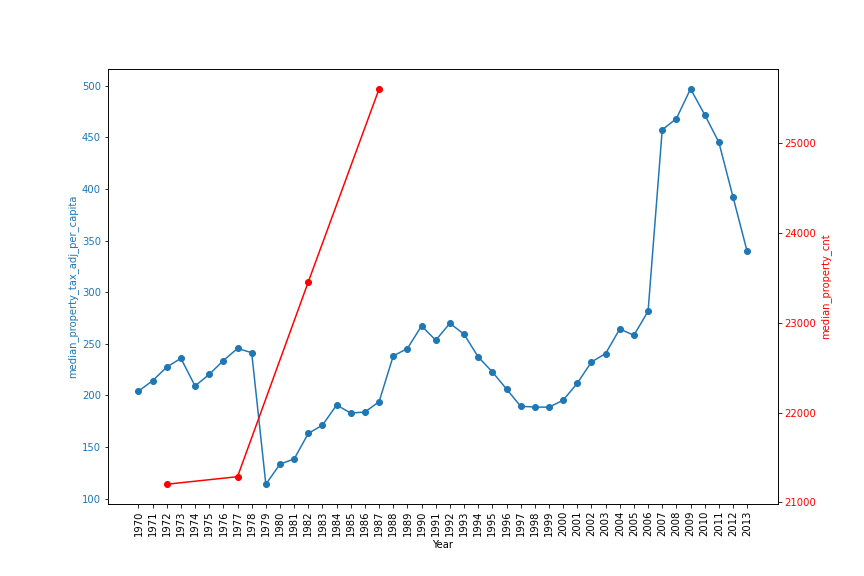

In [75]:
dual_axis_trendlines_with_annotation(merge_with_prop_tax_by_year(median_per_capita_consis, _consis_real_prop_cnt), 
                                     "Year", "median_property_tax_adj_per_capita", "median_property_cnt")

10 consistent cities for ['1967', '1972', '1977', '1982', '1987']
['berkeley city' 'oakland city' 'glendale city' 'long beach city'
 'los angeles city' 'pasadena city' 'torrance city' 'san diego city'
 'san francisco city and county' 'san jose city']


<IPython.core.display.Javascript object>


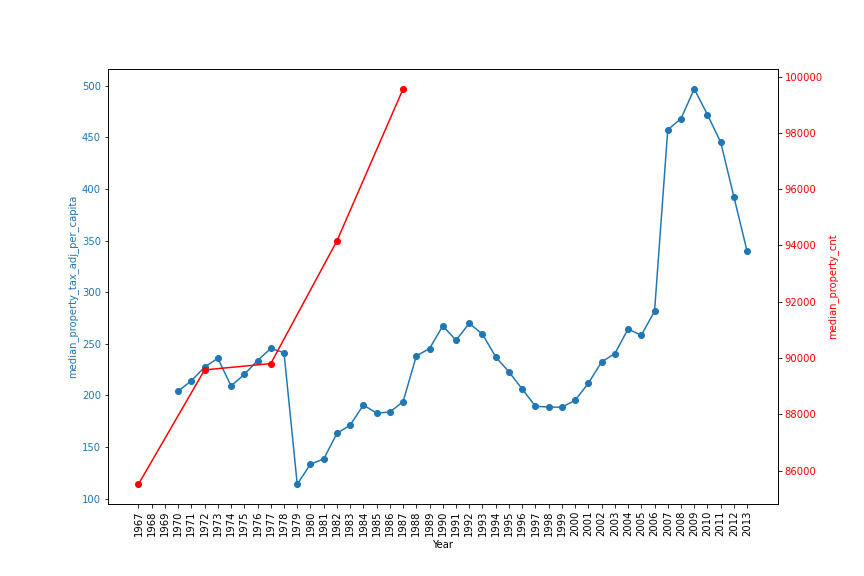

In [76]:
consis_years = [
    "1967",
    "1972","1977","1982","1987"]

_consis_real_prop_cnt = get_consis_cities_median_by_year(consis_real_prop_cnt, consis_years)
dual_axis_trendlines_with_annotation(merge_with_prop_tax_by_year(median_per_capita_consis, _consis_real_prop_cnt), 
                                     "Year", "median_property_tax_adj_per_capita", "median_property_cnt")

# Tax Rate

In [77]:
TAX_RATE_STR_COLS = ["ID", "County", "Area", "Year"]
tax_rates_by_year = pd.read_csv(f"{INTERIM_DATA_DIR}/tax_rates_av_ratio_CA_city_by_year.csv",
                                dtype={col: str for col in TAX_RATE_STR_COLS})
clean_str_cols(tax_rates_by_year, TAX_RATE_STR_COLS)
tax_rates_by_year["ID"] = tax_rates_by_year["ID"].str.zfill(9)
tax_rates_by_year.head(2)

,ID,County,Area,Year,Nom_Tax_Rate_All_Res_Med,Nom_Tax_Rate_Res_All_SFH_Med,Eff_Tax_Rate_All_Res_Med,Eff_Tax_Rate_Res_All_SFH_Med,AV_Ratio_All_Res_Med
0,052001001,alameda county,alameda city,1982,1.19,1.19,0.75,0.75,62.87
1,052001003,alameda county,berkeley city,1982,1.18,1.18,0.61,0.52,51.83


In [78]:
tax_rates_group_by_year = tax_rates_by_year.copy()
tax_rates_group_by_year["Nom_Tax_Rate_All_Res_Med_valid_city_cnt"] = ~tax_rates_group_by_year["Nom_Tax_Rate_All_Res_Med"].isna()
tax_rates_group_by_year["Eff_Tax_Rate_All_Res_Med_valid_city_cnt"] = ~tax_rates_group_by_year["Eff_Tax_Rate_All_Res_Med"].isna()
tax_rates_group_by_year = tax_rates_group_by_year.groupby("Year").agg({"Nom_Tax_Rate_All_Res_Med_valid_city_cnt": sum,
                                                                       "Nom_Tax_Rate_All_Res_Med": np.median,
                                                                       "Eff_Tax_Rate_All_Res_Med_valid_city_cnt": sum,
                                                                       "Eff_Tax_Rate_All_Res_Med": np.median
                                                                      })
tax_rates_group_by_year = tax_rates_group_by_year.reset_index(drop=False)
tax_rates_group_by_year

,Year,Nom_Tax_Rate_All_Res_Med_valid_city_cnt,Nom_Tax_Rate_All_Res_Med,Eff_Tax_Rate_All_Res_Med_valid_city_cnt,Eff_Tax_Rate_All_Res_Med
0,1967,0,NaN,0,NaN
1,1972,61,12.300,61,2.300
2,1977,58,12.405,58,1.905
3,1982,34,1.150,34,0.645


In [79]:
comp_prop_tax_tax_rate = median_per_capita_consis.merge(tax_rates_group_by_year, how="outer", 
                                                        left_on="Year4", right_on="Year")
comp_prop_tax_tax_rate["Year"] = np.where(comp_prop_tax_tax_rate["Year4"].isna(),
                                          comp_prop_tax_tax_rate["Year"],
                                          comp_prop_tax_tax_rate["Year4"])
comp_prop_tax_tax_rate.drop(["Year4", "city_cnt"], axis=1, inplace=True)
comp_prop_tax_tax_rate = comp_prop_tax_tax_rate.sort_values("Year")

<IPython.core.display.Javascript object>


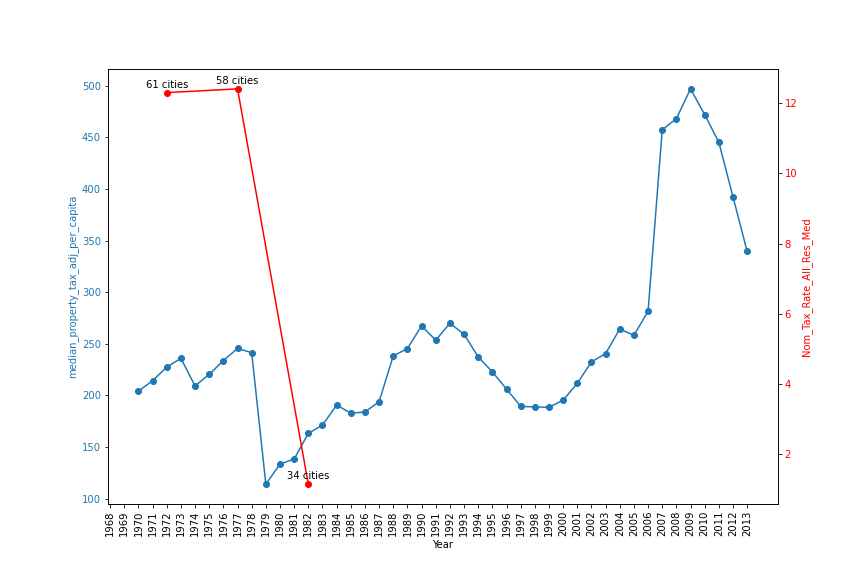

In [80]:
dual_axis_trendlines_with_annotation(comp_prop_tax_tax_rate, "Year", "median_property_tax_adj_per_capita", "Nom_Tax_Rate_All_Res_Med", "Nom_Tax_Rate_All_Res_Med_valid_city_cnt")

<IPython.core.display.Javascript object>


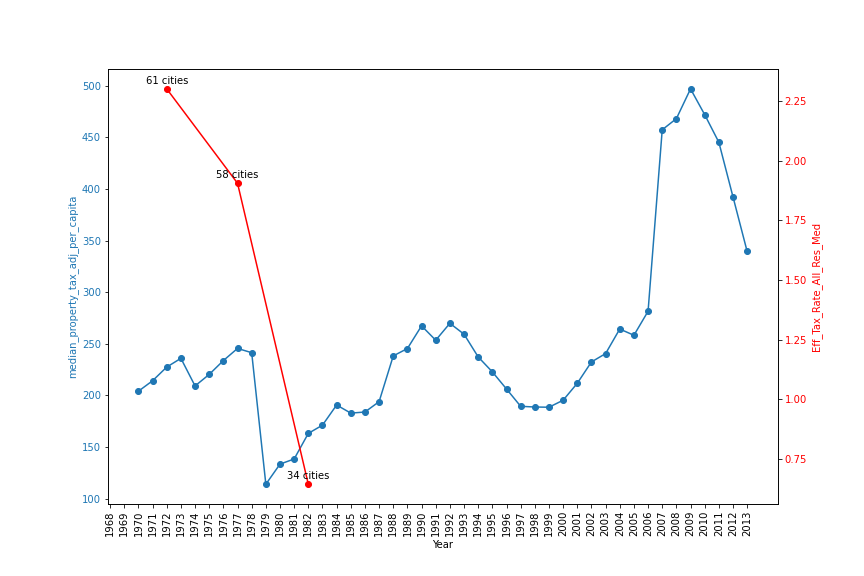

In [81]:
dual_axis_trendlines_with_annotation(comp_prop_tax_tax_rate, "Year", "median_property_tax_adj_per_capita", "Eff_Tax_Rate_All_Res_Med", "Eff_Tax_Rate_All_Res_Med_valid_city_cnt")

## tax rates for 66 consistent cities

In [82]:
tax_rates_by_year
eff_tax_rate_consis = consistent_cities.reset_index().merge(
    tax_rates_by_year[["ID", "Year", "Eff_Tax_Rate_All_Res_Med"]], how="left", on="ID"
)
eff_tax_rate_consis = eff_tax_rate_consis.pivot(index="ID", columns="Year", values="Eff_Tax_Rate_All_Res_Med")

# drop columns with all NA
for c in eff_tax_rate_consis.columns:
    if eff_tax_rate_consis[c].isna().all():
        eff_tax_rate_consis = eff_tax_rate_consis.drop(c, axis=1)
        
eff_tax_rate_consis.reset_index(inplace=True)
eff_tax_rate_consis = eff_tax_rate_consis.merge(ID2city_name, how="left", on="ID")
eff_tax_rate_consis = eff_tax_rate_consis.set_index(["ID", "County", "Name"]).sort_values("Name")

In [83]:
eff_tax_rate_consis.describe()

,1972,1977,1982
count,53.000000,48.000000,27.000000
mean,2.326415,1.931458,0.644074
std,0.344267,0.387018,0.168072
min,1.800000,1.160000,0.310000
25%,2.100000,1.675000,0.585000
50%,2.300000,1.925000,0.650000
75%,2.600000,2.240000,0.720000
max,3.400000,2.900000,1.130000


In [84]:
eff_tax_rate_consis.to_csv(f"{INTERIM_DATA_DIR}/66_consistent_cities_with_effective_tax_rate.csv")

# racial composition

In [85]:
consis_city_name = consistent_cities.reset_index().drop(columns=0).merge(ID2city_name, how="left", on="ID")

In [86]:
consis_city_name[consis_city_name["ID"]=="052056005"]

,ID,County,Name
63,052056005,056,san buenaventura city


## decennial census for 1970, 1980, 1990, 2000, 2010

In [87]:
race_1980 = pd.read_csv(
    f"{INTERIM_DATA_DIR}/CA_race_by_Hispanish_place_1980.csv",
    dtype={col: str for col in [
        'GISJOIN', 'YEAR', 'REGIONA', 'DIVISIONA', 'STATE', 'STATEA', 'SMSAA',
        'COUNTYA', 'CTY_SUBA', 'PLACE', 'PLACEA', 'TRACTA', 'SCSAA',
        'URB_AREAA', 'CDA', 'AIANHHA', 'ZIPA', 'AREANAME']}
)
RACE_1980_COL_MAP = {
    "AREANAME": "AREANAME",
    "non-Hispanic_White": "non-Hispanic_White_1980",
    "total_pop": "total_pop_1980",
}

In [88]:
race_1980 = race_1980[list(RACE_1980_COL_MAP.keys())].rename(columns=RACE_1980_COL_MAP)
consis_city_race = get_race_by_merge(consis_city_name, race_1980, "Name", "AREANAME", "total_pop_1980")

consis_city_race.describe()

,non-Hispanic_White_1980,total_pop_1980
count,6.600000e+01,6.600000e+01
mean,1.047483e+05,1.741499e+05
std,1.885654e+05,3.781581e+05
min,2.104000e+03,1.842800e+04
25%,4.536725e+04,7.518150e+04
50%,6.431350e+04,8.495550e+04
75%,8.775300e+04,1.182850e+05
max,1.419413e+06,2.966850e+06


In [89]:
RACE_CONTEXT_COLS_70 = [
    'GISJOIN',
    'YEAR',
    'STATE',
    'STATEA',
    'COUNTYA',
    'CTY_SUBA',
    'PLACE',
    'PLACEA',
    'TRACTA',
    'ENUMDISTA',
    'SCSAA',
    'SMSAA',
    'URB_AREAA',
    'BLCK_GRPA',
    'BLOCKA',
    'ANXTERRA',
    'URBRURALA',
    'CDA',
    'AREANAME',
    ]
RACE_VAL_COlS_70 = {  
    'CBW001': 'White', 
    'CBW002': 'Negro',
    'CBW003': 'Indian',
    'CBW004': 'Other non-specified races',
    'CBW005': 'Reported other race',
    }
RACE_1970_COL_MAP = {
    "AREANAME": "AREANAME",
    "White": "non-Hispanic_White_1970", # non-hispanic white not availabe
    "total_pop": "total_pop_1970",
}


race_1970 = pd.read_csv(
    f"{RAW_DATA_DIR}/supplemental_data/nhgis0015_csv_race_place_1970/nhgis0015_ds94_1970_place.csv",
    usecols=RACE_CONTEXT_COLS_70 + list(RACE_VAL_COlS_70.keys()),
    dtype={col: str for col in RACE_CONTEXT_COLS_70}
)

race_1970 = race_1970.rename(RACE_VAL_COlS_70, axis=1)
normalize_str_cols(race_1970, RACE_CONTEXT_COLS_70)

race_1970 = race_1970[race_1970["STATEA"] == "06"].reset_index(drop=True)
# checked with total pop from census
race_1970["total_pop"] = race_1970[list(RACE_VAL_COlS_70.values())].sum(axis=1)
print(race_1970["YEAR"].unique())

['1970']


In [90]:
race_1970.loc[race_1970["GISJOIN"] == "g0603004", "AREANAME"] = "san buenaventura (ventura) city"
race_1970.loc[race_1970["GISJOIN"] == "g0602485", "AREANAME"] = "san francisco city"
race_1970 = race_1970[list(RACE_1970_COL_MAP.keys())].rename(columns=RACE_1970_COL_MAP)
consis_city_race = get_race_by_merge(consis_city_race, race_1970, "Name", "AREANAME", "total_pop_1970")

consis_city_race.describe()

,non-Hispanic_White_1980,total_pop_1980,non-Hispanic_White_1970,total_pop_1970
count,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01
mean,1.047483e+05,1.741499e+05,1.295299e+05,1.531202e+05
std,1.885654e+05,3.781581e+05,2.762378e+05,3.568802e+05
min,2.104000e+03,1.842800e+04,1.421300e+04,1.472400e+04
25%,4.536725e+04,7.518150e+04,5.480500e+04,6.032675e+04
50%,6.431350e+04,8.495550e+04,7.161100e+04,7.880100e+04
75%,8.775300e+04,1.182850e+05,9.012375e+04,1.067958e+05
max,1.419413e+06,2.966850e+06,2.173600e+06,2.816061e+06


In [91]:
# get race from 1990 to 2010 from timeseries table
TS_CONTEXT_COLS = [
        "NHGISCODE",
        "GJOIN1980",
        "GJOIN1990",
        "GJOIN2000",
        "GJOIN2010",
        "GJOIN2020",
        "STATE",
        "STATEFP",
        "STATENH",
        "PLACE",
        "PLACEA",
        "NAME1980",
        "NAME1990",
        "NAME2000",
        "NAME2010",
        "NAME2020"]

RACE_90_COLS = [
    "AE7AA1990","AE7AB1990","AE7AC1990","AE7AD1990","AE7AE1990","AE7AG1990","AE7AH1990","AE7AI1990","AE7AJ1990",
    "AE7AK1990"
]
RACE_00_COLS = [
    "AE7AA2000","AE7AB2000","AE7AC2000","AE7AD2000","AE7AE2000","AE7AF2000","AE7AG2000","AE7AH2000","AE7AI2000",
    "AE7AJ2000","AE7AK2000","AE7AL2000"
]
RACE_10_COLS = [
    "AE7AA2010","AE7AB2010","AE7AC2010","AE7AD2010","AE7AE2010","AE7AF2010","AE7AG2010","AE7AH2010","AE7AI2010",
    "AE7AJ2010","AE7AK2010","AE7AL2010"
]
SELECTED_RACE_COL_MAP = {
    # single race
    'AE7AA1990': 'non-Hispanic_White_1990',
    'AE7AA2000': 'non-Hispanic_White_2000',
    'AE7AA2010': 'non-Hispanic_White_2010'
} 
assert (len(RACE_90_COLS) == 10) and (len(set(RACE_90_COLS)) == 10)
assert (len(RACE_00_COLS) == 12) and (len(set(RACE_00_COLS)) == 12)
assert (len(RACE_10_COLS) == 12) and (len(set(RACE_10_COLS)) == 12)

race_ts = pd.read_csv(
    f"{RAW_DATA_DIR}/supplemental_data/nhgis0019_csv_race_place_80to2020/nhgis0019_ts_nominal_place.csv",
    usecols=TS_CONTEXT_COLS + RACE_90_COLS + RACE_00_COLS + RACE_10_COLS,
    dtype={col: str for col in TS_CONTEXT_COLS},
    encoding='latin-1'
)

normalize_str_cols(race_ts, TS_CONTEXT_COLS)
race_ts = race_ts[race_ts["STATEFP"] == "06"].reset_index(drop=True)
print(race_ts["STATE"].unique())

# checked with total pop
race_ts["total_pop_1990"] = race_ts[RACE_90_COLS].sum(axis=1)
race_ts["total_pop_2000"] = race_ts[RACE_00_COLS].sum(axis=1)
race_ts["total_pop_2010"] = race_ts[RACE_10_COLS].sum(axis=1)


['california']


In [92]:
race_ts = race_ts[
    ["PLACE"] + list(SELECTED_RACE_COL_MAP.keys()) + ["total_pop_1990", "total_pop_2000", "total_pop_2010"]
].rename(columns=SELECTED_RACE_COL_MAP)
consis_city_race = get_race_by_merge(consis_city_race, race_ts, "Name", "PLACE", "PLACE")

consis_city_race.describe()

,non-Hispanic_White_1980,total_pop_1980,non-Hispanic_White_1970,total_pop_1970,non-Hispanic_White_1990,non-Hispanic_White_2000,non-Hispanic_White_2010,total_pop_1990,total_pop_2000,total_pop_2010
count,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01
mean,1.047483e+05,1.741499e+05,1.295299e+05,1.531202e+05,1.043640e+05,9.060092e+04,8.334803e+04,2.135219e+05,2.380577e+05,2.516022e+05
std,1.885654e+05,3.781581e+05,2.762378e+05,3.568802e+05,1.772979e+05,1.540331e+05,1.521324e+05,4.452493e+05,4.740626e+05,4.887974e+05
min,2.104000e+03,1.842800e+04,1.421300e+04,1.472400e+04,1.321000e+03,9.540000e+02,7.820000e+02,3.355800e+04,5.676900e+04,6.326400e+04
25%,4.536725e+04,7.518150e+04,5.480500e+04,6.032675e+04,4.517825e+04,3.273375e+04,2.488900e+04,8.774200e+04,9.622725e+04,9.988925e+04
50%,6.431350e+04,8.495550e+04,7.161100e+04,7.880100e+04,6.481850e+04,5.636100e+04,5.123350e+04,1.089880e+05,1.193925e+05,1.254600e+05
75%,8.775300e+04,1.182850e+05,9.012375e+04,1.067958e+05,8.825000e+04,8.333875e+04,7.676625e+04,1.588855e+05,1.824398e+05,1.963540e+05
max,1.419413e+06,2.966850e+06,2.173600e+06,2.816061e+06,1.299604e+06,1.099188e+06,1.086908e+06,3.485398e+06,3.694820e+06,3.792621e+06


## ACS 5-year estimate 2009, 2011-2013

In [93]:
survey_name = "acs5"
years = [2009, 2011, 2012, 2013]
variable2col_map = {
    "B03002_001E": "total_pop",
    "B03002_003E": "non-Hispanic_White", # single race
}
# all the above years are the same


In [94]:
for yr in years:
    print(yr)
    acs_race = CACensusData().get_census_data_by_place(survey_name, yr, variable2col_map)
    consis_city_race = get_race_by_merge(consis_city_race,
                                         acs_race.drop(columns="index"), 
                                         "Name", "place_name", "place_name")


2009
2011
2012
2013


In [95]:
all_yrs = set()
yr_pat = re.compile(r"_(\d{4})$")
for col in consis_city_race.columns:
    match = yr_pat.search(col)
    if match is not None:
        all_yrs.add(match.group(1))

race_str = "non-Hispanic_White"
for yr in all_yrs:
    assert sum(consis_city_race[f"total_pop_{str(yr)}"] == 0) == 0
    consis_city_race[f"pct_{race_str}_{str(yr)}"] = (consis_city_race[f"{race_str}_{str(yr)}"] /
                                                     consis_city_race[f"total_pop_{str(yr)}"])

In [96]:
consis_city_race = consis_city_race[consis_city_race.columns.sort_values()].sort_values("Name").copy()
consis_city_race.columns

Index(['County', 'ID', 'Name', 'non-Hispanic_White_1970',
       'non-Hispanic_White_1980', 'non-Hispanic_White_1990',
       'non-Hispanic_White_2000', 'non-Hispanic_White_2009',
       'non-Hispanic_White_2010', 'non-Hispanic_White_2011',
       'non-Hispanic_White_2012', 'non-Hispanic_White_2013',
       'pct_non-Hispanic_White_1970', 'pct_non-Hispanic_White_1980',
       'pct_non-Hispanic_White_1990', 'pct_non-Hispanic_White_2000',
       'pct_non-Hispanic_White_2009', 'pct_non-Hispanic_White_2010',
       'pct_non-Hispanic_White_2011', 'pct_non-Hispanic_White_2012',
       'pct_non-Hispanic_White_2013', 'total_pop_1970', 'total_pop_1980',
       'total_pop_1990', 'total_pop_2000', 'total_pop_2009', 'total_pop_2010',
       'total_pop_2011', 'total_pop_2012', 'total_pop_2013'],
      dtype='object')

In [97]:
consis_city_race.to_csv(f"{INTERIM_DATA_DIR}/66_consistent_city_with_non-Hispanic_White.csv", index=False)

# gross real property assessed value (breakdown by after tax deduction)

In [98]:
AV_STR_COLS = ['ID', 'State', 'Type', 'County', 'Area', 'Table', 'Page', 'Year', 'Val_Date', 'Notes']
AV_VAL_COLS_MAP = {'GAV_Tot': 'Gross_AV_Total', 
                   'GAV_St': 'Gross_AV_State',
                   'GAV_Loc_Real_Tot': 'Gross_AV_Local_Real_Total',
                   'GAV_Loc_Real_Land': 'Gross_AV_Local_Real_Land',
                   'GAV_Loc_Real_Imprv': 'Gross_AV_Local_Real_Improve',
                   'GAV_Loc_Pers': 'Gross_AV_Local_Personal',
                   'TaxEx_St': 'Tax_Exempt_State',
                   'TaxEx_Loc_Real': 'Tax_Exempt_Local_Real',
                   'TaxEx_Loc_Pers': 'Tax_Exempt_Local_Personal',
                   'NAV_Tot': 'Net_AV_Total',
                   'NAV_St_Tot': 'Net_AV_State_Total',
                   'NAV_Loc_Tot': 'Net_AV_Local_Total',
                   'NAV_Loc_Real': 'Net_AV_Local_Real',
                   'NAV_Loc_Pers': 'Net_AV_Local_Personal'}
assessed_value = pd.read_excel(
    f"{RAW_DATA_DIR}/Prop 13 Resources/Prop-13 Impact Analysis (Kendall)/Assessed Values/TPV - Table CoArea1. Assessed Value of Property Subject to Local General Property Taxation_by Class.xlsx",
    header=0,
    skiprows=[i for i in range(11)],
    dtype={col: str for col in AV_STR_COLS}
)
assessed_value.rename(columns=AV_VAL_COLS_MAP, inplace=True)

In [99]:
assessed_value.columns

Index(['ID', 'State', 'Type', 'County', 'Area', 'Table', 'Page', 'Year',
       'Val_Date', 'Notes', 'Gross_AV_Total', 'Gross_AV_State',
       'Gross_AV_Local_Real_Total', 'Gross_AV_Local_Real_Land',
       'Gross_AV_Local_Real_Improve', 'Gross_AV_Local_Personal',
       'Tax_Exempt_State', 'Tax_Exempt_Local_Real',
       'Tax_Exempt_Local_Personal', 'Net_AV_Total', 'Net_AV_State_Total',
       'Net_AV_Local_Total', 'Net_AV_Local_Real', 'Net_AV_Local_Personal'],
      dtype='object')

In [100]:
CA_assessed_value = assessed_value[assessed_value["State"] == "05"].copy()
CA_assessed_value["Type"].unique()

array(['0', '1', '2'], dtype=object)

In [101]:
"""Type Codes:
0 = State area
1 = County area
2 = Municipal or town government"""

CA_city_assessed_value = CA_assessed_value[CA_assessed_value["Type"] == "2"].copy()

# convert data types
print(CA_city_assessed_value.dtypes)
CA_city_assessed_value["Net_AV_Total"] = pd.to_numeric(CA_city_assessed_value["Net_AV_Total"])
CA_city_assessed_value["Net_AV_Local_Total"] = pd.to_numeric(CA_city_assessed_value["Net_AV_Local_Total"])

ID                             object
State                          object
Type                           object
County                         object
Area                           object
Table                          object
Page                           object
Year                           object
Val_Date                       object
Notes                          object
Gross_AV_Total                  int64
Gross_AV_State                  int64
Gross_AV_Local_Real_Total       int64
Gross_AV_Local_Real_Land        int64
Gross_AV_Local_Real_Improve     int64
Gross_AV_Local_Personal         int64
Tax_Exempt_State                int64
Tax_Exempt_Local_Real           int64
Tax_Exempt_Local_Personal       int64
Net_AV_Total                   object
Net_AV_State_Total              int64
Net_AV_Local_Total             object
Net_AV_Local_Real               int64
Net_AV_Local_Personal           int64
dtype: object


In [102]:
# no id + year duplicates
_dup = CA_city_assessed_value.groupby(["Year", "ID"]).size().to_frame()
assert _dup[_dup[0] > 1].empty

# ID is 9-digits

In [103]:
# clean str columns
clean_str_cols(CA_city_assessed_value, AV_STR_COLS)

In [104]:
check_missing_values_all_cols(CA_city_assessed_value)

{'Page': 306, 'Notes': 436}


In [105]:
CA_city_assessed_value.groupby("Year").size()

Year
1957      1
1962      5
1967     14
1972     67
1977     68
1982     76
1987     90
1992    121
dtype: int64

In [106]:
"""
Flags used in this table:
  A      = For reasons unknown, detail does not sum to equal total or subtotals.
  -11111 = Not available
"""
for col in AV_VAL_COLS_MAP.values():
    CA_city_assessed_value.loc[CA_city_assessed_value[col] == -11111, col] = np.NaN

CA_city_assessed_value.describe()

,Gross_AV_Total,Gross_AV_State,Gross_AV_Local_Real_Total,Gross_AV_Local_Real_Land,Gross_AV_Local_Real_Improve,Gross_AV_Local_Personal,Tax_Exempt_State,Tax_Exempt_Local_Real,Tax_Exempt_Local_Personal,Net_AV_Total,Net_AV_State_Total,Net_AV_Local_Total,Net_AV_Local_Real,Net_AV_Local_Personal
count,4.420000e+02,4.420000e+02,4.420000e+02,0.0,0.0,4.420000e+02,322.0,4.420000e+02,442.000000,4.420000e+02,3.220000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,4.337345e+06,1.115991e+05,3.900592e+06,NaN,NaN,3.251538e+05,0.0,1.192489e+05,5535.346154,4.212561e+06,1.531889e+05,4.100962e+06,3.781343e+06,3.196185e+05
std,1.200972e+07,3.378232e+05,1.099516e+07,NaN,NaN,8.592088e+05,0.0,2.580781e+05,23983.307421,1.177557e+07,3.878105e+05,1.158893e+07,1.076215e+07,8.588694e+05
min,1.041320e+05,0.000000e+00,9.064300e+04,NaN,NaN,3.790000e+03,0.0,3.933000e+03,0.000000,9.901400e+04,4.467000e+03,9.149900e+04,8.640300e+04,3.288000e+03
25%,4.586638e+05,0.000000e+00,3.638782e+05,NaN,NaN,4.652000e+04,0.0,2.685750e+04,0.000000,4.183582e+05,1.581050e+04,3.991225e+05,3.321988e+05,3.909600e+04
50%,2.116942e+06,2.098750e+04,1.890644e+06,NaN,NaN,1.190725e+05,0.0,7.300700e+04,0.000000,2.027482e+06,6.309100e+04,1.929406e+06,1.798934e+06,1.146885e+05
75%,4.285011e+06,9.731100e+04,3.750846e+06,NaN,NaN,2.816425e+05,0.0,1.181470e+05,3251.500000,4.188714e+06,1.271565e+05,4.028005e+06,3.674438e+06,2.671935e+05
max,1.815864e+08,4.354153e+06,1.692075e+08,NaN,NaN,1.237889e+07,0.0,2.819257e+06,430060.000000,1.789671e+08,4.354153e+06,1.789671e+08,1.665882e+08,1.237889e+07


In [107]:
CA_city_assessed_value.to_csv(f"{INTERIM_DATA_DIR}/CA_city_assessed_value.csv", index=False)